In [551]:
from functools import reduce

import folium
import geopandas as gpd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import seaborn as sns

from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.neighbors import KDTree
from xgboost import XGBRegressor

In [885]:
import pickle

with open("saved_vars.pkl", "rb") as f:
    data = pickle.load(f)

In [2]:


df_daily = data["df_daily"]
district_coverage = data["district_coverage"]
miscellaneous_costs = data["miscellaneous_costs"]
chargers_market_price = data["chargers_market_price"]
chargers_gdf = data["chargers_gdf"]
gdf_full_updated = data["gdf_full_updated"]
land_price = data["land_price"]
poi_per_district = data["poi_per_district"]
place_1 = data["place_1"]
districts_gdf = data["districts_gdf"]
distance_long = data["distance_long"]


In [886]:
unique_sites = data['unique_sites']

In [4]:
poi_per_district

,type,longitude,latitude,geometry,district,Permanent population (2020)
5,hospital,114.081323,22.540285,POINT (114.08132 22.54028),futian district,1553225.0
8,cinema,114.113790,22.547825,POINT (114.11379 22.54782),luohu district,1143801.0
24,hospital,114.116354,22.550331,POINT (114.11635 22.55033),luohu district,1143801.0
26,taxi,114.113008,22.533869,POINT (114.11301 22.53387),luohu district,1143801.0
29,parking,114.043383,22.549317,POINT (114.04338 22.54932),futian district,1553225.0
...,...,...,...,...,...,...
46865,parking,114.250127,22.697236,POINT (114.25013 22.69724),longgang district,3979037.0
46866,parking,114.250016,22.696890,POINT (114.25002 22.69689),longgang district,3979037.0
46883,marketplace,114.114538,22.620088,POINT (114.11454 22.62009),longgang district,3979037.0
46928,place_of_worship,114.072758,22.685720,POINT (114.07276 22.68572),longhua district,2528872.0


In [3]:
gdf_full_updated.drop(columns=["index_right"], inplace=True)

In [4]:
gdf_full_updated.head()

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,cost,profit,volume,total_volume,total_duration,population,geometry,district
0,0,2023-04-01,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1850.080734,809.410321,1040.670413,1156.300459,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
1,0,2023-04-02,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1995.843425,873.181498,1122.661927,1247.402141,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
2,0,2023-04-03,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,2501.872783,1094.569343,1407.303440,1563.670489,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
3,0,2023-04-04,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1872.968807,819.423853,1053.544954,1170.605505,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
4,0,2023-04-05,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1863.798165,815.411697,1048.386468,1164.873853,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district


# Function to define the cost

In [7]:
type(chargers_market_price)

pandas.core.frame.DataFrame

In [8]:
land_price

,district,price
0,futian district,44605.40
1,nanshan district,41419.30
2,luohu district,39826.25
3,bao'an district,35047.10
4,longhua district,31861.00
5,longgang district,30267.95
6,yantian district,30267.95
7,pingshan district,25488.80
8,guangming district,23895.75
9,dapeng new district,22302.70


In [5]:
def estimate_site_investment(
    district: str,
    area_sqm: float,
    charger_type: str,
    num_chargers: int,
    land_price: pd.DataFrame,  # columns: ['district','price_per_m2']
    chargers_market_price: pd.DataFrame,  # {'AC_slow':5000, ...}
    misc_costs: pd.DataFrame,  # {'installation':6000, 'grid_connection':2000, 'site_preparation_and_base':1000}
    misc_split=(
        "per_charger",
        {"installation", "site_preparation_and_base"},
        {
            "grid_connection",
        },
    ),  # (mode, per_charger_set, per_site_set)
    contingency_pct: float = 0.05,  # 5% contingency
) -> dict:
    """Return a breakdown dict with totals and each component."""
    # --- land ---
    row = land_price.loc[
        land_price["district"].str.lower().str.strip() == district.lower().strip()
    ]
    if row.empty:
        raise ValueError(f"District '{district}' not found in land_price_df.")
    price_per_m2 = float(row["price"].iloc[0])
    land_cost = area_sqm * price_per_m2

    # --- hardware ---
    charger_row = chargers_market_price.loc[
        chargers_market_price["charger_type"].str.lower().str.strip()
        == charger_type.lower().strip()
    ]
    if charger_row.empty:
        raise ValueError(
            f"Charger type '{charger_type}' not found in chargers_market_price."
        )
    unit_price = float(charger_row["price"].iloc[0])
    hardware_cost = num_chargers * unit_price

    # --- misc ---
    misc_costs_dict = dict(
        zip(misc_costs["service"].str.lower().str.strip(), misc_costs["price"])
    )

    per_charger_keys = {k.lower().strip() for k in misc_split[1]}
    per_site_keys = {k.lower().strip() for k in misc_split[2]}

    misc_per_charger_sum = sum(misc_costs_dict.get(k, 0) for k in per_charger_keys)
    misc_per_site_sum = sum(misc_costs_dict.get(k, 0) for k in per_site_keys)
    misc_cost = num_chargers * misc_per_charger_sum + misc_per_site_sum

    # --- subtotal & contingency ---
    subtotal = land_cost + hardware_cost + misc_cost
    contingency = contingency_pct * subtotal
    total = subtotal + contingency

    return {
        "district": district,
        "area_sqm": area_sqm,
        "charger_type": charger_type,
        "num_chargers": num_chargers,
        "price_per_m2": price_per_m2,
        "unit_price": unit_price,
        "land_cost": land_cost,
        "hardware_cost": hardware_cost,
        "misc_cost": misc_cost,
        "contingency_pct": contingency_pct,
        "contingency": contingency,
        "total_investment": total,
    }

In [10]:
place_1

,geometry,district,population,total_volume,volume_per_capita,sites_per_100k,price_m2
0,POINT (113.84423 22.81057),bao'an district,4476554.0,3.632798e+07,8.115166,4.132643,35047.1


In [11]:
miscellaneous_costs

,service,price
0,installation,6000
1,grid_connection,2000
2,site_preparation_and_base,1000


In [6]:
try_place_1 = estimate_site_investment(
    district="bao'an district",
    area_sqm=100.0,
    charger_type="DC_fast",
    num_chargers=2,
    land_price=land_price,
    chargers_market_price=chargers_market_price,
    misc_costs=miscellaneous_costs,
    contingency_pct=0.05,
)

print(try_place_1)

{'district': "bao'an district", 'area_sqm': 100.0, 'charger_type': 'DC_fast', 'num_chargers': 2, 'price_per_m2': 35047.1, 'unit_price': 80000.0, 'land_cost': 3504710.0, 'hardware_cost': 160000.0, 'misc_cost': 16000, 'contingency_pct': 0.05, 'contingency': 184035.5, 'total_investment': 3864745.5}


In [7]:
import geopandas as gpd
from shapely.geometry import Point


def attach_site_context(
    lat: float,
    lon: float,
    districts_gdf: gpd.GeoDataFrame,
    district_coverage: pd.DataFrame,
    land_price: pd.DataFrame,
):

    pt = gpd.GeoDataFrame(
        {"lat": [lat], "lon": [lon]}, geometry=[Point(lon, lat)], crs="EPSG:4326"
    )

    hit = gpd.sjoin(pt, districts_gdf, how="left", predicate="within")
    if hit.empty or hit["district"].isna().all():
        raise ValueError(
            "Point does not fall within any district polygon (check CRS/bounds)."
        )
    district = hit["district"].iloc[0]

    cov = district_coverage.rename(columns={"district": "district_name"})
    lp = land_price.rename(columns={"district": "district_name"})
    ctx = (
        pd.DataFrame({"district_name": [district], "lat": [lat], "lon": [lon]})
        .merge(cov, on="district_name", how="left")
        .merge(lp, on="district_name", how="left")
    )
    return ctx

In [8]:
place_1 = attach_site_context(
    lat=22.810568,
    lon=113.844234,
    districts_gdf=districts_gdf,
    district_coverage=district_coverage,
    land_price=land_price,
)
district_for_place_1 = place_1["district_name"].iloc[0]

In [11]:
place_1

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,bao'an district,22.810568,113.844234,185,36327979.0,4476554.0,8.115166,4.132643,1.963675,35047.1


In [9]:
inv = estimate_site_investment(
    district=district_for_place_1,
    area_sqm=100,
    charger_type="DC_fast",
    num_chargers=2,
    land_price=land_price,
    chargers_market_price=chargers_market_price,
    misc_costs=miscellaneous_costs,
)
total_investment = inv["total_investment"]
total_investment

3864745.5

In [10]:
place_2 = attach_site_context(
    lat=22.655490,
    lon=114.024749,
    districts_gdf=districts_gdf,
    district_coverage=district_coverage,
    land_price=land_price,
)
district_for_place_2 = place_2["district_name"].iloc[0]

In [14]:
place_2

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,longhua district,22.65549,114.024749,128,18914300.0,2528872.0,7.479343,5.061545,1.47768,31861.0


In [11]:
inv_place_2 = estimate_site_investment(
    district=district_for_place_2,
    area_sqm=40,
    charger_type="DC_slow",
    num_chargers=4,
    land_price=land_price,
    chargers_market_price=chargers_market_price,
    misc_costs=miscellaneous_costs,
)
total_investment_place_2 = inv_place_2["total_investment"]
total_investment_place_2

1579662.0

# Predict K Nearest Neighbors

In [12]:
distance_long = distance_long[distance_long["distance"] > 0]

In [13]:
distance_long

,from_site_id,to_site_id,distance
1,1,0,2.496200
2,3,0,3.515668
3,4,0,4.375921
4,5,0,2.933117
5,6,0,12.755135
...,...,...,...
1901635,1439,1444,41.779702
1901636,1440,1444,18.537879
1901637,1441,1444,27.970158
1901638,1442,1444,33.077632


In [14]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    p1 = np.radians(lat1)
    p2 = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(p1) * np.cos(p2) * np.sin(dlon / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

In [15]:
def calculate_new_site_distances(new_site, df_sites):
    distances = []
    for _, row in df_sites.iterrows():
        d = haversine_km(
            new_site["lat"], new_site["lon"], row["latitude"], row["longitude"]
        )
        distances.append(
            {"from_site_id": "new", "to_site_id": row["site_id"], "distance": d}
        )
    return pd.DataFrame(distances)

In [24]:
place_2_distances = calculate_new_site_distances(place_2, df_sites=gdf_full_updated)

In [25]:
place_2_distances = place_2_distances.drop_duplicates(subset=["to_site_id"])

In [26]:
place_2_distances["distance"] = place_2_distances["distance"].astype(str)
place_2_distances["distance"] = place_2_distances["distance"].str.split().str[-3]

In [27]:
place_2_distances.sort_values("distance").head(20)

,from_site_id,to_site_id,distance
140544,new,439,0.276732
179157,new,636,0.358559
85095,new,148,0.398619
4026,new,1017,0.427856
135420,new,413,0.63725
20130,new,1104,0.655408
233325,new,91,0.741935
195627,new,716,0.811144
103029,new,247,0.827267
174216,new,612,0.936836


In [16]:
def estimate_profit_from_neighbors(new_site_distances, gdf_full_updated, k=5):
    nearest = new_site_distances.sort_values("distance").head(k)
    nearest = nearest.merge(
        gdf_full_updated[["site_id", "profit"]],
        left_on="to_site_id",
        right_on="site_id",
    )

    nearest["weight"] = 1 / (nearest["distance"] + 0.01)
    weighted_profit = (nearest["profit"] * nearest["weight"]).sum() / nearest[
        "weight"
    ].sum()
    return weighted_profit

## Using functions to build places

In [29]:
place_1

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,bao'an district,22.810568,113.844234,185,36327979.0,4476554.0,8.115166,4.132643,1.963675,35047.1


In [17]:
place_1 = attach_site_context(
    lat=22.81057,
    lon=113.84423,
    districts_gdf=districts_gdf,
    district_coverage=district_coverage,
    land_price=land_price,
)

In [199]:
place_1_distances = calculate_new_site_distances(place_1, df_sites=gdf_full_updated)

In [200]:
place_1_distances = place_1_distances.drop_duplicates(subset=["to_site_id"])

In [201]:
place_1_distances["distance"] = place_1_distances["distance"].astype(str)
place_1_distances["distance"] = place_1_distances["distance"].str.split().str[-3]

In [202]:
place_1_distances["distance"] = place_1_distances["distance"].astype(float)

In [203]:
place_1_distances

,from_site_id,to_site_id,distance
0,new,0,42.325726
183,new,1,41.158512
366,new,10,37.423245
549,new,100,38.049323
732,new,1000,39.940106
...,...,...,...
248331,new,994,32.894716
248514,new,995,32.675850
248697,new,996,32.778025
248880,new,997,35.229370


In [20]:
gdf_full_updated

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,cost,profit,volume,total_volume,total_duration,population,geometry,district
0,0,2023-04-01,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1850.080734,809.410321,1040.670413,1156.300459,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
1,0,2023-04-02,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1995.843425,873.181498,1122.661927,1247.402141,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
2,0,2023-04-03,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,2501.872783,1094.569343,1407.303440,1563.670489,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
3,0,2023-04-04,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1872.968807,819.423853,1053.544954,1170.605505,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
4,0,2023-04-05,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1863.798165,815.411697,1048.386468,1164.873853,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248509,999,2023-09-26,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district
248510,999,2023-09-27,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district
248511,999,2023-09-28,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district
248512,999,2023-09-29,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district


In [18]:
closest_neighbors = (
    distance_long.sort_values("distance").groupby("from_site_id").head(5)
)

In [38]:
distance_long["to_site_id"] = distance_long["to_site_id"].astype(int)
distance_long["from_site_id"] = distance_long["from_site_id"].astype(int)

/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_64230/83279870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_long['to_site_id'] = distance_long['to_site_id'].astype(int)
/var/folders/sp/j31td69s1fsg02f7tz1kfv9m0000gn/T/ipykernel_64230/83279870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_long['from_site_id'] = distance_long['from_site_id'].astype(int)


In [19]:
gdf_full_updated["site_id"] = gdf_full_updated["site_id"].astype(int)

In [40]:
gdf_full_updated

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,cost,profit,volume,total_volume,total_duration,population,geometry,district
0,0,2023-04-01,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1850.080734,809.410321,1040.670413,1156.300459,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
1,0,2023-04-02,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1995.843425,873.181498,1122.661927,1247.402141,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
2,0,2023-04-03,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,2501.872783,1094.569343,1407.303440,1563.670489,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
3,0,2023-04-04,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1872.968807,819.423853,1053.544954,1170.605505,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
4,0,2023-04-05,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1863.798165,815.411697,1048.386468,1164.873853,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248509,999,2023-09-26,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district
248510,999,2023-09-27,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district
248511,999,2023-09-28,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district
248512,999,2023-09-29,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,739.200000,950.400000,1056.000000,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district


In [20]:
import pandas as pd


def add_daily_neighbor_features_vectorized(gdf_full_updated, distance_long):
    """
    df_daily: daily data for all sites (site_id, date, volume, num_of_chargers, ...)
    distance_long: distances between sites (from_site_id, to_site_id, distance)
    k: number of closest neighbors to consider
    """

    distance_sorted = distance_long.sort_values("distance")
    distance_topk = distance_sorted.groupby("from_site_id").head(10)

    df_neighbors = gdf_full_updated.rename(
        columns={
            "site_id": "to_site_id",
            "volume": "neighbor_volume",
            "num_of_chargers": "neighbor_num_chargers",
        }
    )[["to_site_id", "timestamp", "neighbor_volume", "neighbor_num_chargers"]]

    merged = distance_topk.merge(df_neighbors, on="to_site_id", how="left")

    agg_neighbors = (
        merged.groupby(["from_site_id", "timestamp"])
        .agg({"neighbor_volume": "mean", "neighbor_num_chargers": "sum"})
        .reset_index()
        .rename(
            columns={
                "from_site_id": "site_id",
                "neighbor_volume": "10_neighbors_avg_volume",
                "neighbor_num_chargers": "10_neighbors_total_chargers",
            }
        )
    )

    df_final = gdf_full_updated.merge(
        agg_neighbors, on=["site_id", "timestamp"], how="left"
    )

    return df_final

In [42]:
df_for_modeling = add_daily_neighbor_features_vectorized(
    gdf_full_updated, distance_long
)

In [43]:
df_for_modeling.head()

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,cost,profit,volume,total_volume,total_duration,population,geometry,district,10_neighbors_avg_volume,10_neighbors_total_chargers
0,0,2023-04-01,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1850.080734,809.410321,1040.670413,1156.300459,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,184.626884,15.0
1,0,2023-04-02,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1995.843425,873.181498,1122.661927,1247.402141,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,208.038584,15.0
2,0,2023-04-03,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,2501.872783,1094.569343,1407.303440,1563.670489,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,188.854759,15.0
3,0,2023-04-04,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1872.968807,819.423853,1053.544954,1170.605505,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,205.065859,15.0
4,0,2023-04-05,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1863.798165,815.411697,1048.386468,1164.873853,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,189.455435,15.0


In [44]:
X = df_for_modeling[
    [
        "num_of_chargers",
        "charger_type",
        "population",
        "10_neighbors_avg_volume",
        "10_neighbors_total_chargers",
        "district",
    ]
]
y = df_for_modeling["volume"]

In [107]:
def preprocess(df):

    num_transformer = make_pipeline(StandardScaler())
    cat_transformer = make_pipeline(OneHotEncoder())

    preprocessor = ColumnTransformer(
        [
            (
                "num_transformer",
                num_transformer,
                make_column_selector(dtype_include="number"),
            ),
            (
                "cat_transformer",
                cat_transformer,
                make_column_selector(dtype_include="object"),
            ),
        ]
    )
    return preprocessor

In [47]:
preprocess(df_for_modeling)

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x32aa4e150>),
                                ('cat_transformer',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x32aa4d8e0>)])

In [104]:
def preprocessor_pipeline(regression_model, df=None):

    if df is not None:
        preprocessor = preprocess(df)
    else:
        preprocessor = preprocess

    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", regression_model)]
    )
    return pipeline

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [50]:
pipeline = preprocessor_pipeline(LinearRegression(), df_for_modeling)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x32aa860c0>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x32aa85f10>)])),
                ('model', LinearRegression())])

In [105]:
def predict_regression_models(regression_model, X_train, X_test, y_train, df):
    pipe_classification = preprocessor_pipeline(regression_model, df=df)
    pipe_classification.fit(X_train, y_train)
    y_pred = pipe_classification.predict(X_test)
    return y_pred, pipe_classification

In [52]:
y_pred, tuned_pipe = predict_regression_models(
    LinearRegression(), X_train, X_test, y_train, df_for_modeling
)

In [53]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.0615
Mean Absolute Error: 604.74
Root Mean Squared Error: 1563.02


In [54]:
results_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
print(results_df.head(10))

        Actual    Predicted
0  3578.321485   729.719390
1    87.919431   564.732050
2  1056.000000   679.550190
3   134.166667   443.066323
4   800.750000   703.102742
5    94.758013   457.641950
6   210.000000   372.601008
7   294.000000  1608.482633
8   698.833333   323.236905
9    14.000000  1128.153091


In [55]:
rf_model = RandomForestRegressor(random_state=42)
param_grid = {"n_estimators": [175, 200, 225], "max_depth": [23, 25, 27]}

grid_search = GridSearchCV(
    estimator=rf_model, param_grid=param_grid, scoring="r2", cv=2, n_jobs=-1, verbose=1
)

In [56]:
y_pred_grid, tuned_pipe_grid = predict_regression_models(
    grid_search, X_train, X_test, y_train, df_for_modeling
)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "/Users/alexvelasco/.pyenv/versions/lewagon/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/Users/alexvelasco/.pyenv/versions/lewagon/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alexvelasco/.pyenv/versions/lewagon/lib/python3.12/site-packages/debugpy/_v

In [57]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=23, n_estimators=175, random_state=42)

In [58]:
print("Best params:", grid_search.best_params_)

Best params: {'max_depth': 23, 'n_estimators': 175}


In [59]:
r2 = r2_score(y_test, y_pred_grid)
mae = mean_absolute_error(y_test, y_pred_grid)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_grid))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.6714
Mean Absolute Error: 252.64
Root Mean Squared Error: 924.86


In [60]:
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=20, random_state=42, max_features="sqrt", n_jobs=-1
)

pipeline_rf = preprocessor_pipeline(rf_model, df_for_modeling)
y_pred, tuned_pipe = predict_regression_models(
    rf_model, X_train, X_test, y_train, df_for_modeling
)

In [61]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.7129
Mean Absolute Error: 249.89
Root Mean Squared Error: 864.42


## Add POI to the df. How many POI is there to the site within 2 km?

In [21]:
poi_per_district

,type,longitude,latitude,geometry,district,Permanent population (2020)
5,hospital,114.081323,22.540285,POINT (114.08132 22.54028),futian district,1553225.0
8,cinema,114.113790,22.547825,POINT (114.11379 22.54782),luohu district,1143801.0
24,hospital,114.116354,22.550331,POINT (114.11635 22.55033),luohu district,1143801.0
26,taxi,114.113008,22.533869,POINT (114.11301 22.53387),luohu district,1143801.0
29,parking,114.043383,22.549317,POINT (114.04338 22.54932),futian district,1553225.0
...,...,...,...,...,...,...
46865,parking,114.250127,22.697236,POINT (114.25013 22.69724),longgang district,3979037.0
46866,parking,114.250016,22.696890,POINT (114.25002 22.69689),longgang district,3979037.0
46883,marketplace,114.114538,22.620088,POINT (114.11454 22.62009),longgang district,3979037.0
46928,place_of_worship,114.072758,22.685720,POINT (114.07276 22.68572),longhua district,2528872.0


In [93]:
def poi_counts_within_2km(site_static, poi_df, radius_km=2.0):
    sites_rad = np.radians(site_static[['latitude','longitude']].values)
    poi_rad   = np.radians(poi_df[['latitude','longitude']].values)
    tree = BallTree(poi_rad, metric='haversine')
    r = radius_km / 6371.0  # km -> radians
    ind = tree.query_radius(sites_rad, r=r)
    counts = np.array([len(ix) for ix in ind])
    out = site_static[['site_id']].copy()
    out['poi_within_2km'] = counts
    return out

poi_counts = poi_counts_within_2km(site_static, poi_per_district, radius_km=2.0)
gdf_full_updated = gdf_full_updated.merge(poi_counts, on='site_id', how='left').fillna({'poi_within_2km':0})
gdf_full_updated.head()

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,...,population,geometry,district,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km_x,poi_within_2km_y,poi_within_2km
0,0,2023-04-01,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1850.080734,...,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22,22,22
1,0,2023-04-02,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1995.843425,...,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22,22,22
2,0,2023-04-03,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,2501.872783,...,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22,22,22
3,0,2023-04-04,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1872.968807,...,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22,22,22
4,0,2023-04-05,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1863.798165,...,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22,22,22


In [96]:
gdf_full_updated.drop(columns=['poi_within_2km_y', 'poi_within_2km_x'], inplace=True)

In [97]:
gdf_full_updated.head()

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,...,total_volume,total_duration,population,geometry,district,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km
0,0,2023-04-01,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1850.080734,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
1,0,2023-04-02,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1995.843425,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
2,0,2023-04-03,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,2501.872783,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
3,0,2023-04-04,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1872.968807,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
4,0,2023-04-05,0.7,0.9,114.142651,22.54775,4,7.0,AC_fast,1863.798165,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22


In [539]:
def count_poi_near_sites(sites_df, poi_df, radius_km=2.0):

    from math import asin, cos, radians, sin, sqrt

    # Haversine vectorized
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2[:, None] - lat1
        dlon = lon2[:, None] - lon1
        a = (
            np.sin(dlat / 2) ** 2
            + np.cos(lat1) * np.cos(lat2[:, None]) * np.sin(dlon / 2) ** 2
        )
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    site_lats = sites_df["latitude"].values
    site_lons = sites_df["longitude"].values
    poi_lats = poi_df["latitude"].values
    poi_lons = poi_df["longitude"].values

    dist_matrix = haversine(
        poi_lats, poi_lons, site_lats, site_lons
    )  # shape: (num_pois, num_sites)
    counts = (dist_matrix <= radius_km).sum(axis=0)

    sites_df["poi_within_2km"] = counts
    return sites_df

## Add nearby sites to the df. How many sites is there to the site within 2 km?

In [66]:
site_static = (
    gdf_full_updated
      .groupby('site_id', as_index=False)
      .agg(
          latitude=('latitude','first'),
          longitude=('longitude','first'),
          num_chargers=('num_of_chargers','max'),     # or 'first'
          avg_daily_volume=('volume','mean')          # site’s average day
      )
)
site_static

,site_id,latitude,longitude,num_chargers,avg_daily_volume
0,0,22.547750,114.142651,4,1557.339704
1,1,22.541244,114.119416,1,170.929417
2,3,22.540594,114.109352,1,100.021940
3,4,22.579000,114.116610,1,520.024590
4,5,22.543569,114.114493,1,452.015027
...,...,...,...,...,...
1350,1440,22.629165,114.086330,1,8571.724238
1351,1441,22.713154,114.026166,1,3564.493295
1352,1442,22.526603,113.944227,1,134.826503
1353,1443,22.569144,114.055040,1,111.037341


In [72]:
nearby2 = distance_long.loc[
    (distance_long['distance'] <= 2) &
    (distance_long['from_site_id'] != distance_long['to_site_id']),
    ['from_site_id','to_site_id']
]

# attach neighbor stats (no daily explosion)
nearby2 = nearby2.merge(
    site_static[['site_id','num_chargers','avg_daily_volume']],
    left_on='to_site_id', right_on='site_id', how='left'
)
nearby2

,from_site_id,to_site_id,site_id,num_chargers,avg_daily_volume
0,96,0,0.0,4.0,1557.339704
1,198,0,0.0,4.0,1557.339704
2,239,0,0.0,4.0,1557.339704
3,261,0,0.0,4.0,1557.339704
4,262,0,0.0,4.0,1557.339704
...,...,...,...,...,...
42627,992,1444,1444.0,1.0,279.366699
42628,1264,1444,1444.0,1.0,279.366699
42629,1352,1444,1444.0,1.0,279.366699
42630,1353,1444,1444.0,1.0,279.366699


In [69]:
neighbor_feats = (
    nearby2
      .groupby('from_site_id', as_index=False)
      .agg(
          sites_within_2km=('to_site_id','nunique'),        # number of neighbor sites
          chargers_within_2km=('num_chargers','sum'),       # total neighbor chargers
          neighbor_avg_daily_volume_2km=('avg_daily_volume','mean'),  # avg neighbor day
          neighbor_sum_daily_volume_2km=('avg_daily_volume','sum')    # total neighbor day
      )
      .rename(columns={'from_site_id':'site_id'})
)

# ensure every site has a row
neighbor_feats = (
    neighbor_feats
      .set_index('site_id')
      .reindex(site_static['site_id'])
      .fillna(0)
      .reset_index()
)

In [81]:
neighbor_feats["neighbor_avg_daily_volume_2km"] = neighbor_feats["neighbor_avg_daily_volume_2km"].round(2)
neighbor_feats["neighbor_sum_daily_volume_2km"] = neighbor_feats["neighbor_sum_daily_volume_2km"].round(2)

In [173]:
neighbor_feats

,site_id,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km
0,0,28,45,269.21,7537.83
1,1,59,92,317.47,18730.70
2,3,60,95,339.97,20398.10
3,4,52,86,608.32,31632.50
4,5,68,107,321.41,21855.87
...,...,...,...,...,...
1350,1440,20,32,802.71,16054.12
1351,1441,3,5,577.97,1733.90
1352,1442,34,48,350.75,11574.65
1353,1443,40,65,286.23,11449.18


In [83]:
gdf_full_updated = gdf_full_updated.merge(neighbor_feats, on='site_id', how='left')

In [86]:
gdf_full_updated.drop(columns=['sites_within_2km_x' , 'chargers_within_2km_x', 'neighbor_avg_daily_volume_2km_x', 'neighbor_sum_daily_volume_2km_x'], inplace=True)

In [88]:
gdf_full_updated = gdf_full_updated.rename(columns={'sites_within_2km_y': 'sites_within_2km'})
gdf_full_updated = gdf_full_updated.rename(columns={'chargers_within_2km_y': 'chargers_within_2km'})
gdf_full_updated = gdf_full_updated.rename(columns={'neighbor_avg_daily_volume_2km_y': 'neighbor_avg_daily_volume_2km'})
gdf_full_updated = gdf_full_updated.rename(columns={'neighbor_sum_daily_volume_2km_y': 'neighbor_sum_daily_volume_2km'})

In [175]:
gdf_full_updated

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,...,total_volume,total_duration,population,geometry,district,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km
0,0,2023-04-01,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1850.080734,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
1,0,2023-04-02,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1995.843425,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
2,0,2023-04-03,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,2501.872783,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
3,0,2023-04-04,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1872.968807,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
4,0,2023-04-05,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1863.798165,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249241,999,2023-09-26,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43
249242,999,2023-09-27,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43
249243,999,2023-09-28,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43
249244,999,2023-09-29,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43


In [174]:
gdf_full_updated.columns

Index(['site_id', 'timestamp', 'e_price', 's_price', 'longitude', 'latitude',
       'num_of_chargers', 'avg_power', 'charger_type', 'revenue', 'cost',
       'profit', 'volume', 'total_volume', 'total_duration', 'population',
       'geometry', 'district', 'sites_within_2km', 'chargers_within_2km',
       'neighbor_avg_daily_volume_2km', 'neighbor_sum_daily_volume_2km',
       'poi_within_2km'],
      dtype='object')

In [99]:
X = gdf_full_updated[
    [
        "num_of_chargers",
        "charger_type",
        "population",
        "sites_within_2km",
        "chargers_within_2km",
        "neighbor_avg_daily_volume_2km",
        "neighbor_sum_daily_volume_2km",
        "poi_within_2km",
        "district",
    ]
]
y = gdf_full_updated["volume"]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [108]:
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=20, random_state=42, max_features="sqrt", n_jobs=-1
)

pipeline_rf = preprocessor_pipeline(rf_model, gdf_full_updated)
y_pred, tuned_pipe = predict_regression_models(
    rf_model, X_train, X_test, y_train, gdf_full_updated
)

In [109]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.9905
Mean Absolute Error: 49.43
Root Mean Squared Error: 158.14


### 100% there is data leakage... time series and not shuffled

In [110]:
gdf_full_updated[["volume", "neighbor_avg_daily_volume_2km"]].corr()

,volume,neighbor_avg_daily_volume_2km
volume,1.000000,0.163151
neighbor_avg_daily_volume_2km,0.163151,1.000000


In [111]:
rf_model.feature_importances_

array([0.10805424, 0.03655936, 0.13377278, 0.13029058, 0.17928905,
       0.20641765, 0.11868388, 0.01867368, 0.00100061, 0.00092091,
       0.01262719, 0.0124556 , 0.00780857, 0.00491834, 0.02327893,
       0.00445278, 0.00079584])

In [123]:
features = [ 
        "num_of_chargers",
        "population",
        "sites_within_2km",
        "chargers_within_2km",
        "neighbor_avg_daily_volume_2km",
        "neighbor_sum_daily_volume_2km",
        "poi_within_2km",
        "volume"
    ]

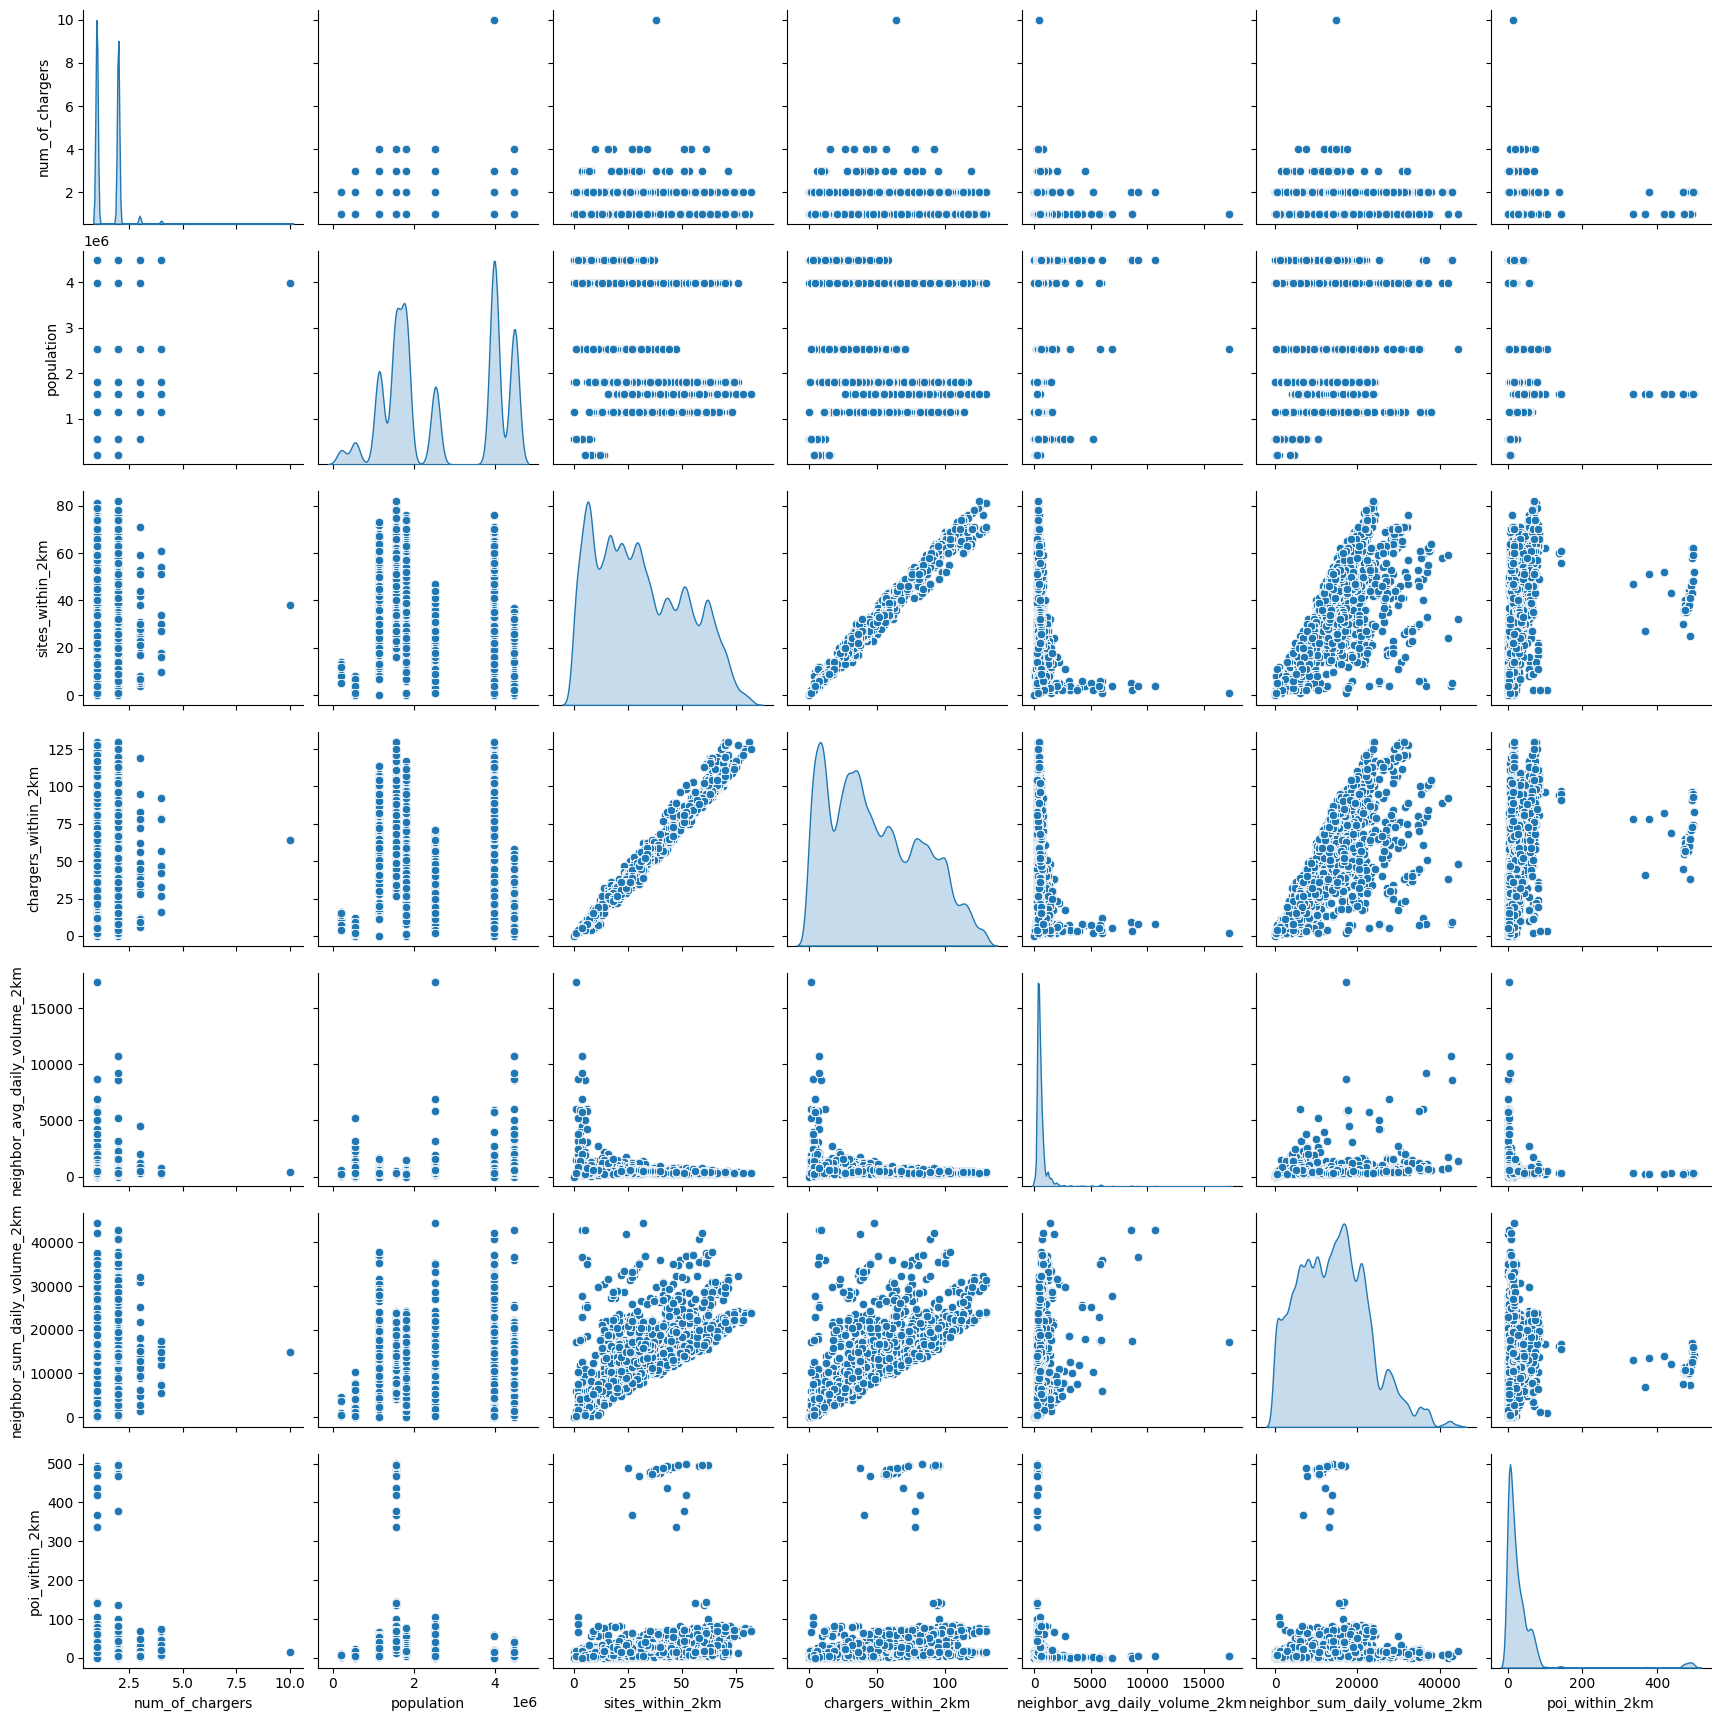

In [118]:
sns.pairplot(gdf_full_updated[features], diag_kind='kde')
plt.show()

In [124]:
gdf_full_updated[features].corr()

,num_of_chargers,population,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km,volume
num_of_chargers,1.000000,-0.025189,0.110499,0.114184,-0.058694,0.087404,0.029713,0.082389
population,-0.025189,1.000000,-0.309555,-0.283596,0.212550,0.036416,-0.266518,0.128113
sites_within_2km,0.110499,-0.309555,1.000000,0.991056,-0.285896,0.680229,0.256681,-0.190407
chargers_within_2km,0.114184,-0.283596,0.991056,1.000000,-0.276440,0.690721,0.245216,-0.187077
neighbor_avg_daily_volume_2km,-0.058694,0.212550,-0.285896,-0.276440,1.000000,0.184705,-0.131110,0.163151
neighbor_sum_daily_volume_2km,0.087404,0.036416,0.680229,0.690721,0.184705,1.000000,0.001890,-0.084542
poi_within_2km,0.029713,-0.266518,0.256681,0.245216,-0.131110,0.001890,1.000000,-0.081968
volume,0.082389,0.128113,-0.190407,-0.187077,0.163151,-0.084542,-0.081968,1.000000


### Data leakage confirmed

In [125]:
new_df_for_modeling = gdf_full_updated[[
    "num_of_chargers",
    "charger_type",
    "population",
    "sites_within_2km",
    "chargers_within_2km",
    "neighbor_avg_daily_volume_2km",
    "neighbor_sum_daily_volume_2km",
    "poi_within_2km",
    "district",
    "volume"
]]

In [130]:
X = new_df_for_modeling.drop(columns=['volume'])
y = new_df_for_modeling['volume']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42
)

In [131]:
X_train.head()

,num_of_chargers,charger_type,population,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km,district
81367,1,AC_fast,1795826.0,32,47,345.14,10699.19,58,nanshan district
185549,1,AC_fast,2528872.0,7,8,733.51,5134.60,5,longhua district
100693,2,AC_fast,2528872.0,11,19,720.57,7926.30,4,longhua district
168567,1,AC_fast,1143801.0,46,76,661.34,30421.82,9,luohu district
204801,1,AC_fast,2528872.0,7,8,672.09,4704.60,4,longhua district


In [128]:
pipeline_rf = preprocessor_pipeline(rf_model, df=new_df_for_modeling)
y_pred, tuned_pipe = predict_regression_models(
    rf_model, X_train, X_test, y_train, new_df_for_modeling
)

In [132]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
R² Score: 0.9897
Mean Absolute Error: 49.72
Root Mean Squared Error: 164.09


## Dealing with timestamps

In [140]:
model_features = [
    "num_of_chargers",
    "charger_type",
    "population",
    "sites_within_2km",
    "chargers_within_2km",
    "neighbor_avg_daily_volume_2km",
    "neighbor_sum_daily_volume_2km",
    "poi_within_2km",
    "district",
    "volume",
    "site_id",
    "latitude",
    "longitude",
    "timestamp" 
]

df_model = gdf_full_updated[model_features].copy()

In [141]:
train_list, test_list = [], []

for site in df_model['site_id'].unique():
    site_df = df_model[df_model['site_id'] == site].sort_values('timestamp')
    split_idx = int(0.7 * len(site_df))
    train_list.append(site_df.iloc[:split_idx])
    test_list.append(site_df.iloc[split_idx:])

df_train = pd.concat(train_list).reset_index(drop=True)
df_test = pd.concat(test_list).reset_index(drop=True)

X_train = df_train.drop(columns=['volume', 'site_id', 'timestamp'])
y_train = df_train['volume']
X_test = df_test.drop(columns=['volume', 'site_id', 'timestamp'])
y_test = df_test['volume']

In [135]:
pipeline_rf = preprocessor_pipeline(rf_model, df=df_train)
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)

In [136]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.9877
Mean Absolute Error: 55.35
Root Mean Squared Error: 180.25


## Columns neighbor_sum_daily_volume_2km and neighbor_avg_daily_volume_2km are leaking

In [142]:
df_train

,num_of_chargers,charger_type,population,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km,district,volume,site_id,latitude,longitude,timestamp
0,4,AC_fast,1143801.0,28,45,269.21,7537.83,22,luohu district,1156.300459,0,22.547750,114.142651,2023-04-01
1,4,AC_fast,1143801.0,28,45,269.21,7537.83,22,luohu district,1247.402141,0,22.547750,114.142651,2023-04-02
2,4,AC_fast,1143801.0,28,45,269.21,7537.83,22,luohu district,1563.670489,0,22.547750,114.142651,2023-04-03
3,4,AC_fast,1143801.0,28,45,269.21,7537.83,22,luohu district,1170.605505,0,22.547750,114.142651,2023-04-04
4,4,AC_fast,1143801.0,28,45,269.21,7537.83,22,luohu district,1164.873853,0,22.547750,114.142651,2023-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174331,2,AC_fast,1553225.0,51,81,274.04,13975.86,43,futian district,1056.000000,999,22.550918,114.039323,2023-08-02
174332,2,AC_fast,1553225.0,51,81,274.04,13975.86,43,futian district,1056.000000,999,22.550918,114.039323,2023-08-03
174333,2,AC_fast,1553225.0,51,81,274.04,13975.86,43,futian district,1056.000000,999,22.550918,114.039323,2023-08-04
174334,2,AC_fast,1553225.0,51,81,274.04,13975.86,43,futian district,1056.000000,999,22.550918,114.039323,2023-08-05


In [150]:
df_train[['latitude', 'longitude']] = np.radians(df_train[['latitude', 'longitude']])
df_test[['latitude', 'longitude']] = np.radians(df_test[['latitude', 'longitude']])

In [152]:
train_coords = df_train[['latitude', 'longitude']].to_numpy()
test_coords = df_test[['latitude', 'longitude']].to_numpy()
train_volumes = df_train['volume'].to_numpy()

# Build KDTree on training locations
tree = KDTree(train_coords, metric='euclidean')  # If lat/lon in radians; use 'euclidean' if projected

# Radius = 2 km, convert to radians if using haversine: radius_km / earth_radius_km
radius_km = 2
earth_radius_km = 6371
radius = radius_km / earth_radius_km

# Query neighbors
neighbors_idx = tree.query_radius(test_coords, r=radius)

# Compute sum and avg daily volume for test set
neighbor_sum = np.array([train_volumes[idx].sum() for idx in neighbors_idx])
neighbor_avg = np.array([train_volumes[idx].mean() if len(idx) > 0 else 0 for idx in neighbors_idx])

# Assign to test dataframe
df_test['neighbor_sum_daily_volume_2km'] = neighbor_sum
df_test['neighbor_avg_daily_volume_2km'] = neighbor_avg

In [153]:
X_test['neighbor_sum_daily_volume_2km'] = df_test['neighbor_sum_daily_volume_2km']
X_test['neighbor_avg_daily_volume_2km'] = df_test['neighbor_avg_daily_volume_2km']

In [154]:
pipeline_rf = preprocessor_pipeline(rf_model, df=df_train)
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)

In [155]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.5266
Mean Absolute Error: 549.24
Root Mean Squared Error: 1117.98


In [160]:
xgb_reg = XGBRegressor()

In [170]:
pipeline_xgb = preprocessor_pipeline(xgb_reg, df=df_train)
pipeline_xgb.fit(X_train, y_train)
y_pred_reg = pipeline_xgb.predict(X_test)

In [171]:
r2 = r2_score(y_test, y_pred_reg)
mae = mean_absolute_error(y_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.0639
Mean Absolute Error: 997.21
Root Mean Squared Error: 1572.11


In [165]:
pipeline_xgb = preprocessor_pipeline(xgb_reg, df=df_train)
y_pred_reg, tuned_pipe = predict_regression_models(
    xgb_reg, X_train, X_test, y_train, df_train
)

In [166]:
r2 = r2_score(y_test, y_pred_reg)
mae = mean_absolute_error(y_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.0639
Mean Absolute Error: 997.21
Root Mean Squared Error: 1572.11


# Predict new site performance with KNN 
## Let's calculate how much the new site its expected to sell in volume

In [172]:
place_1

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,bao'an district,22.81057,113.84423,185,36327979.0,4476554.0,8.115166,4.132643,1.963675,35047.1


In [176]:
place_2

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,longhua district,22.65549,114.024749,128,18914300.0,2528872.0,7.479343,5.061545,1.47768,31861.0


In [185]:
df_sites = gdf_full_updated.groupby('site_id').agg({
    'num_of_chargers': 'first',  # static
    'charger_type': 'first',     # static
    'population': 'first',       # static
    'sites_within_2km': 'first', # static
    'chargers_within_2km': 'first', # static
    'neighbor_avg_daily_volume_2km': 'first', # static
    'neighbor_sum_daily_volume_2km': 'first', # static
    'poi_within_2km': 'first',   # static
    'district': 'first',         # static
    'volume': 'sum'             # target: average daily volume
}).reset_index()

In [180]:
gdf_full_updated['volume']

0         1156.300459
1         1247.402141
2         1563.670489
3         1170.605505
4         1164.873853
             ...     
249241    1056.000000
249242    1056.000000
249243    1056.000000
249244    1056.000000
249245    1056.000000
Name: volume, Length: 249246, dtype: float64

In [187]:
df_sites['volume'] = df_sites['volume'].round(2)

In [192]:
df_sites

,site_id,num_of_chargers,charger_type,population,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km,district,volume
0,0,4,AC_fast,1143801.0,28,45,269.21,7537.83,22,luohu district,284993.17
1,1,1,AC_fast,1143801.0,59,92,317.47,18730.70,45,luohu district,31280.08
2,3,1,AC_fast,1143801.0,60,95,339.97,20398.10,55,luohu district,18304.02
3,4,1,AC_fast,1143801.0,52,86,608.32,31632.50,6,luohu district,95164.50
4,5,1,AC_fast,1143801.0,68,107,321.41,21855.87,52,luohu district,82718.75
...,...,...,...,...,...,...,...,...,...,...,...
1350,1440,1,Ultra_fast,3979037.0,20,32,802.71,16054.12,1,longgang district,1568625.54
1351,1441,1,DC_fast,2528872.0,3,5,577.97,1733.90,1,longhua district,652302.27
1352,1442,1,AC_slow,1795826.0,34,48,350.75,11574.65,39,nanshan district,24673.25
1353,1443,1,AC_slow,1553225.0,40,65,286.23,11449.18,476,futian district,20319.83


In [215]:
place_1_distances.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1355 entries, 0 to 249063
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   from_site_id  1355 non-null   object 
 1   to_site_id    1355 non-null   int64  
 2   distance      1355 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 42.3+ KB


In [206]:
df_sites

,site_id,num_of_chargers,charger_type,population,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km,district,volume
0,0,4,AC_fast,1143801.0,28,45,269.21,7537.83,22,luohu district,284993.17
1,1,1,AC_fast,1143801.0,59,92,317.47,18730.70,45,luohu district,31280.08
2,3,1,AC_fast,1143801.0,60,95,339.97,20398.10,55,luohu district,18304.02
3,4,1,AC_fast,1143801.0,52,86,608.32,31632.50,6,luohu district,95164.50
4,5,1,AC_fast,1143801.0,68,107,321.41,21855.87,52,luohu district,82718.75
...,...,...,...,...,...,...,...,...,...,...,...
1350,1440,1,Ultra_fast,3979037.0,20,32,802.71,16054.12,1,longgang district,1568625.54
1351,1441,1,DC_fast,2528872.0,3,5,577.97,1733.90,1,longhua district,652302.27
1352,1442,1,AC_slow,1795826.0,34,48,350.75,11574.65,39,nanshan district,24673.25
1353,1443,1,AC_slow,1553225.0,40,65,286.23,11449.18,476,futian district,20319.83


In [230]:
radius_km = 6  
min_neighbors = 10 

# Filter by radius first
nearby_place_1 = place_1_distances.loc[
    (place_1_distances['from_site_id'] == 'new') &
    (place_1_distances['distance'] <= radius_km)
].copy()


if len(nearby_place_1) < min_neighbors:
    nearby_place_1 = place_1_distances.loc[
        place_1_distances['from_site_id'] == 'new'
    ].nsmallest(min_neighbors, 'distance')

In [231]:
nearby_place_1

,from_site_id,to_site_id,distance
2562,new,101,5.599862
26718,new,1141,5.047343
27450,new,1145,5.188055
55632,new,1293,5.686051
57645,new,1305,5.172180
59109,new,1312,3.848264
65331,new,1343,4.754843
66429,new,135,2.830639
87474,new,161,4.630269
114009,new,304,5.632997


In [233]:
site_static

,site_id,latitude,longitude,num_chargers,avg_daily_volume
0,0,22.547750,114.142651,4,1557.339704
1,1,22.541244,114.119416,1,170.929417
2,3,22.540594,114.109352,1,100.021940
3,4,22.579000,114.116610,1,520.024590
4,5,22.543569,114.114493,1,452.015027
...,...,...,...,...,...
1350,1440,22.629165,114.086330,1,8571.724238
1351,1441,22.713154,114.026166,1,3564.493295
1352,1442,22.526603,113.944227,1,134.826503
1353,1443,22.569144,114.055040,1,111.037341


In [247]:
distance_long

,from_site_id,to_site_id,distance
1,1,0,2.496200
2,3,0,3.515668
3,4,0,4.375921
4,5,0,2.933117
5,6,0,12.755135
...,...,...,...
1901635,1439,1444,41.779702
1901636,1440,1444,18.537879
1901637,1441,1444,27.970158
1901638,1442,1444,33.077632


In [262]:
import pandas as pd

def build_df_sites_radius_from_daily(
    gdf_full_updated, 
    distance_long, 
    radius_km=2,
    neighbor_cols=['num_of_chargers','charger_type'],
    target_col='volume'
):
    """
    Build site-level DataFrame with neighbor features computed for any radius
    from daily volume data.
    """

    # --- 1. Compute site-level info ---
    site_info = gdf_full_updated.groupby('site_id').agg(
        num_of_chargers=('num_of_chargers','first'),
        charger_type=('charger_type','first'),
        population=('population','first'),
        poi_within_2km=('poi_within_2km','first'),
        district=('district','first'),
        avg_daily_volume=(target_col,'mean')
    ).reset_index()

    # --- 2. Filter neighbors within radius ---
    nearby = distance_long.loc[
        (distance_long['distance'] <= radius_km) &
        (distance_long['from_site_id'] != distance_long['to_site_id']),
        ['from_site_id','to_site_id']
    ]

    # --- 3. Merge neighbor info ---
    if not nearby.empty:
        nearby = nearby.merge(
            site_info[['site_id'] + neighbor_cols + ['avg_daily_volume']],
            left_on='to_site_id', right_on='site_id', how='left'
        )

        # --- 4. Aggregate neighbor features ---
        neighbor_feats = (
            nearby.groupby('from_site_id', as_index=False)
            .agg(
                **{
                    f'sites_within_{radius_km}km': ('to_site_id','nunique'),
                    f'chargers_within_{radius_km}km': ('num_of_chargers','sum'),
                    f'neighbor_avg_daily_volume_{radius_km}km': ('avg_daily_volume','mean'),
                    f'neighbor_sum_daily_volume_{radius_km}km': ('avg_daily_volume','sum')
                }
            )
        )
    else:
        # If no neighbors found, create empty DataFrame with correct columns
        neighbor_feats = pd.DataFrame({
            'from_site_id': site_info['site_id'],
            f'sites_within_{radius_km}km': 0,
            f'chargers_within_{radius_km}km': 0,
            f'neighbor_avg_daily_volume_{radius_km}km': 0,
            f'neighbor_sum_daily_volume_{radius_km}km': 0
        })

    # --- 5. Ensure all sites included ---
    # Merge with site_info; neighbor_feats always has 'from_site_id' now
    df_sites_radius = site_info.merge(
        neighbor_feats,
        left_on='site_id', right_on='from_site_id',
        how='left'
    ).drop(columns=['from_site_id'])

    return df_sites_radius

In [265]:
df_sites_6km = build_df_sites_radius_from_daily(
    gdf_full_updated=gdf_full_updated,
    distance_long=distance_long,
    radius_km=6
)

df_sites_6km.head()

,site_id,num_of_chargers,charger_type,population,poi_within_2km,district,avg_daily_volume,sites_within_6km,chargers_within_6km,neighbor_avg_daily_volume_6km,neighbor_sum_daily_volume_6km
0,0,4,AC_fast,1143801.0,22,luohu district,1557.339704,171,272.0,409.599184,70041.460428
1,1,1,AC_fast,1143801.0,45,luohu district,170.929417,194,307.0,397.085273,77034.543046
2,3,1,AC_fast,1143801.0,55,luohu district,100.021940,232,366.0,375.499805,87115.954649
3,4,1,AC_fast,1143801.0,6,luohu district,520.024590,255,399.0,540.942668,137399.437625
4,5,1,AC_fast,1143801.0,52,luohu district,452.015027,215,338.0,388.660512,83562.010140


In [268]:
place_1

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,bao'an district,22.81057,113.84423,185,36327979.0,4476554.0,8.115166,4.132643,1.963675,35047.1


In [269]:
import pandas as pd

def build_df_place_to_predict(place, df_sites_6km, place_1_distances, num_chargers, charger_type, radius_km=6, min_neighbors=10):
    """
    Build a DataFrame for a new site (place_1) compatible with df_sites_6km,
    computing neighbor features from df_sites_6km using place_1_distances.

    Parameters:
    - place: single-row DataFrame with columns like ['district_name','population', ...]
    - df_sites_6km: site-level DataFrame with neighbor features for existing sites
    - place_1_distances: DataFrame with ['from_site_id','to_site_id','distance'] for the new site
    - num_chargers: planned number of chargers for the new site
    - charger_type: planned charger type ('DC_fast', etc.)
    - radius_km: max distance to consider neighbors
    - min_neighbors: minimum neighbors to include (fallback to nearest if not enough)
    
    Returns:
    - place_1_df: DataFrame with the same columns as df_sites_6km
    """

    # --- 1. Filter neighbors within radius ---
    nearby = place_1_distances.loc[place_1_distances['from_site_id'] == 'new']
    nearby = nearby[nearby['distance'] <= radius_km]

    # Ensure at least min_neighbors
    if len(nearby) < min_neighbors:
        nearby = place_1_distances.loc[place_1_distances['from_site_id'] == 'new'].nsmallest(min_neighbors, 'distance')

    # --- 2. Merge neighbor info from df_sites_6km ---
    neighbor_cols = ['site_id','num_of_chargers','avg_daily_volume','charger_type','poi_within_2km']
    nearby = nearby.merge(df_sites_6km[neighbor_cols],
                          left_on='to_site_id', right_on='site_id', how='left')

    # --- 3. Compute neighbor features ---
    neighbor_feats = {
        'sites_within_6km': nearby['to_site_id'].nunique(),
        'chargers_within_6km': nearby['num_of_chargers'].sum(),
        'neighbor_avg_daily_volume_6km': nearby['avg_daily_volume'].mean(),
        'neighbor_sum_daily_volume_6km': nearby['avg_daily_volume'].sum(),
        'poi_within_2km': nearby['poi_within_2km'].mean()  # use average POI of neighbors
    }

    # --- 4. Build final DataFrame ---
    place_1_df = pd.DataFrame([{
        'num_of_chargers': num_chargers,
        'charger_type': charger_type,
        'population': place['population'].values[0],
        'district': place['district_name'].values[0],
        'avg_daily_volume': 0,  # unknown, to be predicted
        **neighbor_feats
    }])

    return place_1_df

In [362]:
place_1_df = build_df_place_to_predict(place_1, df_sites_6km, place_1_distances, num_chargers=4, charger_type='DC_fast', radius_km=6, min_neighbors=10)

In [272]:
place_1_df

,num_of_chargers,charger_type,population,district,avg_daily_volume,sites_within_6km,chargers_within_6km,neighbor_avg_daily_volume_6km,neighbor_sum_daily_volume_6km,poi_within_2km
0,4,DC_fast,4476554.0,bao'an district,0,17,25,3314.375977,56344.391605,3.529412


In [276]:
df_sites_6km.head()

,site_id,num_of_chargers,charger_type,population,poi_within_2km,district,avg_daily_volume,sites_within_6km,chargers_within_6km,neighbor_avg_daily_volume_6km,neighbor_sum_daily_volume_6km
0,0,4,AC_fast,1143801.0,22,luohu district,1557.339704,171,272.0,409.599184,70041.460428
1,1,1,AC_fast,1143801.0,45,luohu district,170.929417,194,307.0,397.085273,77034.543046
2,3,1,AC_fast,1143801.0,55,luohu district,100.021940,232,366.0,375.499805,87115.954649
3,4,1,AC_fast,1143801.0,6,luohu district,520.024590,255,399.0,540.942668,137399.437625
4,5,1,AC_fast,1143801.0,52,luohu district,452.015027,215,338.0,388.660512,83562.010140


In [288]:
def knn_custom_predict(new_point, df_sites, k_all, k_same_type, weight_type=0.6):
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import NearestNeighbors
    
    # Use only average neighbor volumes, not sums
    features = ['num_of_chargers','population','sites_within_6km','chargers_within_6km',
                'neighbor_avg_daily_volume_6km','poi_within_2km']
    
    X = df_sites[features].values
    y = df_sites['avg_daily_volume'].values
    types = df_sites['charger_type'].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    new_point_scaled = scaler.transform(new_point[features].values.reshape(1,-1))

    # --- Model A: General Neighbors ---
    nn_all = NearestNeighbors(n_neighbors=min(k_all,len(X_scaled)))
    nn_all.fit(X_scaled)
    idx_all = nn_all.kneighbors(new_point_scaled, return_distance=False)[0]
    pred_all = y[idx_all].mean()

    # --- Model B: Same Charger Type ---
    mask_type = (types == new_point['charger_type'].values[0])
    X_same = X_scaled[mask_type]
    y_same = y[mask_type]
    if len(X_same) == 0:
        pred_same = pred_all  # fallback if no neighbors of same type
    else:
        nn_same = NearestNeighbors(n_neighbors=min(k_same_type,len(X_same)))
        nn_same.fit(X_same)
        idx_same = nn_same.kneighbors(new_point_scaled, return_distance=False)[0]
        pred_same = y_same[idx_same].mean()

    return weight_type * pred_same + (1 - weight_type) * pred_all

In [291]:
place_1_prediction = knn_custom_predict(place_1_df, df_sites_6km, k_all=10, k_same_type=5, weight_type=0.7)

In [292]:
place_1_prediction

4085.3492806864706

In [295]:
place_1_df

,num_of_chargers,charger_type,population,district,avg_daily_volume,sites_within_6km,chargers_within_6km,neighbor_avg_daily_volume_6km,neighbor_sum_daily_volume_6km,poi_within_2km
0,4,DC_fast,4476554.0,bao'an district,0,17,25,3314.375977,56344.391605,3.529412


In [296]:
place_1_df['neighbor_avg_per_site'] = place_1_df['neighbor_sum_daily_volume_6km'] / place_1_df['sites_within_6km'].replace(0,1)

In [297]:
place_1_df

,num_of_chargers,charger_type,population,district,avg_daily_volume,sites_within_6km,chargers_within_6km,neighbor_avg_daily_volume_6km,neighbor_sum_daily_volume_6km,poi_within_2km,neighbor_avg_per_site
0,4,DC_fast,4476554.0,bao'an district,0,17,25,3314.375977,56344.391605,3.529412,3314.375977


In [298]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

def knn_custom_predict_realistic(new_point, df_sites, k_all=10, k_same_type=5, weight_type=0.7):
    """
    Predict daily avg volume for a new site using KNN with:
    - k_all nearest neighbors (any charger type)
    - k_same_type nearest neighbors (same charger type)
    Scales neighbor features to prevent extreme values in dense/high-volume areas.
    """

    # --- 1. Preprocess neighbor features ---
    df_sites = df_sites.copy()

    # Compute per-site neighbor volume to avoid huge sums
    df_sites['neighbor_avg_per_site'] = df_sites['neighbor_sum_daily_volume_6km'] / df_sites['sites_within_6km'].replace(0,1)

    # Clip extreme values (optional, helps underserved predictions)

    # --- 2. Features for KNN ---
    features = ['num_of_chargers','population','poi_within_2km','neighbor_avg_per_site']
    X = df_sites[features].values
    y = df_sites['avg_daily_volume'].values
    types = df_sites['charger_type'].values

    # --- 3. Scale features ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    new_point_scaled = scaler.transform(new_point[features].values.reshape(1,-1))

    # --- 4. KNN on all neighbors ---
    nn_all = NearestNeighbors(n_neighbors=min(k_all,len(X_scaled)))
    nn_all.fit(X_scaled)
    idx_all = nn_all.kneighbors(new_point_scaled, return_distance=False)[0]
    pred_all = y[idx_all].mean()

    # --- 5. KNN on same charger type ---
    mask_type = (types == new_point['charger_type'].values[0])
    X_same = X_scaled[mask_type]
    y_same = y[mask_type]

    if len(X_same) == 0:
        pred_same = pred_all  # fallback if no neighbors of same type
    else:
        nn_same = NearestNeighbors(n_neighbors=min(k_same_type,len(X_same)))
        nn_same.fit(X_same)
        idx_same = nn_same.kneighbors(new_point_scaled, return_distance=False)[0]
        pred_same = y_same[idx_same].mean()

    # --- 6. Weighted prediction ---
    return weight_type * pred_same + (1 - weight_type) * pred_all

In [299]:
place_1_prediction_2 = knn_custom_predict_realistic(place_1_df, df_sites_6km, k_all=10, k_same_type=5, weight_type=0.7)

In [300]:
place_1_prediction_2

4085.3492806864706

In [323]:
predicted_volume = predict_new_site_volume(
    place_1_df=place_1_df,
    df_sites_6km=df_sites_6km,
    place_1_distances=place_1_distances,
    radius_km=4,
    k_all=10,
    k_same_type=2,
    weight_type=0.7
)

print("Predicted daily volume for new site:", predicted_volume)

Predicted daily volume for new site: 5416.180177595628


In [324]:
import pandas as pd
import numpy as np

def predict_new_site_volume_distance_weighted(place_1_df, df_sites_6km, place_1_distances,
                                              radius_km=6, max_distance_km=4,
                                              k_all=10, k_same_type=5, weight_type=0.7,
                                              min_neighbors_baseline=3, baseline_factor=0.3):
    """
    Predict realistic daily volume for a new site using actual neighbors and distance weighting.
    
    Parameters:
    - place_1_df: 1-row DataFrame with new site features (charger_type etc.)
    - df_sites_6km: existing sites with 'site_id', 'avg_daily_volume', 'charger_type'
    - place_1_distances: distances from 'new' site to all existing sites
    - radius_km: max radius to consider neighbors
    - max_distance_km: max distance for weighting neighbors
    - k_all: number of closest neighbors (any type)
    - k_same_type: number of closest neighbors with same charger type
    - weight_type: weight of same-type neighbors in final prediction
    - min_neighbors_baseline: minimum neighbors to fallback on baseline
    - baseline_factor: fraction of overall mean for baseline prediction
    
    Returns:
    - predicted daily volume (float)
    """
    
    # --- 1. Select neighbors within radius ---
    nearby = place_1_distances.loc[place_1_distances['from_site_id']=='new'].copy()
    nearby = nearby[nearby['distance'] <= radius_km]
    
    # fallback if too few neighbors
    if len(nearby) < min_neighbors_baseline:
        nearby = place_1_distances.loc[place_1_distances['from_site_id']=='new'].nsmallest(min_neighbors_baseline, 'distance')

    # --- 2. Merge neighbor avg_daily_volume and charger_type ---
    nearby = nearby.merge(df_sites_6km[['site_id','avg_daily_volume','charger_type']],
                          left_on='to_site_id', right_on='site_id', how='left')
    
    # --- 3. Compute distance weights ---
    # Closer neighbors get higher weight, beyond max_distance_km weight=0
    nearby['weight'] = np.clip(max_distance_km - nearby['distance'], 0, None)
    if nearby['weight'].sum() == 0:
        nearby['weight'] = 1.0  # fallback equal weights if all distances > max_distance_km

    # --- 4. k_all weighted average ---
    nn_all = nearby.nsmallest(k_all, 'distance')
    pred_all = np.average(nn_all['avg_daily_volume'], weights=nn_all['weight'])

    # --- 5. k_same_type weighted average ---
    same_type = nearby[nearby['charger_type']==place_1_df['charger_type'].values[0]]
    if same_type.empty:
        pred_same = pred_all
    else:
        nn_same = same_type.nsmallest(k_same_type, 'distance')
        pred_same = np.average(nn_same['avg_daily_volume'], weights=nn_same['weight'])

    # --- 6. Weighted final prediction ---
    predicted_volume = weight_type * pred_same + (1 - weight_type) * pred_all

    # --- 7. Fallback baseline if too few neighbors ---
    if len(nearby) < min_neighbors_baseline:
        avg_neighbor = df_sites_6km['avg_daily_volume'].mean()
        predicted_volume = baseline_factor * avg_neighbor + (1 - baseline_factor) * predicted_volume

    return predicted_volume

In [327]:
predicted_volume = predict_new_site_volume_distance_weighted(
    place_1_df=place_1_df,
    df_sites_6km=df_sites_6km,
    place_1_distances=place_1_distances,
    radius_km=6,
    max_distance_km=4,
    k_all=10,
    k_same_type=1,
    weight_type=0.7
)

print("Predicted daily volume for new site:", predicted_volume)

ZeroDivisionError: Weights sum to zero, can't be normalized

In [328]:
import pandas as pd
import numpy as np

def predict_new_site_volume_distance_weighted(place_1_df, df_sites_6km, place_1_distances,
                                              radius_km=6, max_distance_km=4,
                                              k_all=10, k_same_type=5, weight_type=0.7,
                                              min_neighbors_baseline=3, baseline_factor=0.3):
    """
    Predict realistic daily volume for a new site using actual neighbors and distance weighting.
    Handles zero-weight neighbors safely.
    """
    
    # --- 1. Select neighbors within radius ---
    nearby = place_1_distances.loc[place_1_distances['from_site_id']=='new'].copy()
    nearby = nearby[nearby['distance'] <= radius_km]
    
    # fallback if too few neighbors
    if len(nearby) < min_neighbors_baseline:
        nearby = place_1_distances.loc[place_1_distances['from_site_id']=='new'].nsmallest(min_neighbors_baseline, 'distance')

    # --- 2. Merge neighbor avg_daily_volume and charger_type ---
    nearby = nearby.merge(df_sites_6km[['site_id','avg_daily_volume','charger_type']],
                          left_on='to_site_id', right_on='site_id', how='left')
    
    # --- 3. Compute distance weights ---
    nearby['weight'] = np.clip(max_distance_km - nearby['distance'], 0, None)

    # --- 4. k_all weighted average ---
    nn_all = nearby.nsmallest(k_all, 'distance')
    if nn_all['weight'].sum() > 0:
        pred_all = np.average(nn_all['avg_daily_volume'], weights=nn_all['weight'])
    else:
        pred_all = nn_all['avg_daily_volume'].mean()  # fallback to unweighted mean

    # --- 5. k_same_type weighted average ---
    same_type = nearby[nearby['charger_type']==place_1_df['charger_type'].values[0]]
    if same_type.empty:
        pred_same = pred_all
    else:
        nn_same = same_type.nsmallest(k_same_type, 'distance')
        if nn_same['weight'].sum() > 0:
            pred_same = np.average(nn_same['avg_daily_volume'], weights=nn_same['weight'])
        else:
            pred_same = nn_same['avg_daily_volume'].mean()  # fallback

    # --- 6. Weighted final prediction ---
    predicted_volume = weight_type * pred_same + (1 - weight_type) * pred_all

    # --- 7. Fallback baseline if too few neighbors ---
    if len(nearby) < min_neighbors_baseline:
        avg_neighbor = df_sites_6km['avg_daily_volume'].mean()
        predicted_volume = baseline_factor * avg_neighbor + (1 - baseline_factor) * predicted_volume

    return predicted_volume

In [329]:
predicted_volume = predict_new_site_volume_distance_weighted(
    place_1_df=place_1_df,
    df_sites_6km=df_sites_6km,
    place_1_distances=place_1_distances,
    radius_km=6,
    max_distance_km=4,
    k_all=10,
    k_same_type=1,
    weight_type=0.7
)

print("Predicted daily volume for new site:", predicted_volume)

Predicted daily volume for new site: 5130.2166939005265


In [330]:
import pandas as pd
import numpy as np

def predict_new_site_volume_realistic(place_1_df, df_sites_6km, place_1_distances,
                                      effective_radius_km=3, k_all=10, k_same_type=5,
                                      weight_type=0.7, baseline_factor=0.3):
    """
    Predict realistic daily volume for a new site in underserved areas.
    
    Parameters:
    - place_1_df: 1-row DataFrame with new site features (charger_type)
    - df_sites_6km: existing sites with 'site_id', 'avg_daily_volume', 'charger_type'
    - place_1_distances: distances from 'new' site to all existing sites
    - effective_radius_km: distance beyond which neighbor influence decays rapidly
    - k_all: number of closest neighbors (any type)
    - k_same_type: number of closest neighbors with same charger type
    - weight_type: weight of same-type neighbors
    - baseline_factor: fraction of overall mean if no neighbors nearby
    
    Returns:
    - predicted daily volume (float)
    """
    # --- 1. Select neighbors ---
    nearby = place_1_distances.loc[place_1_distances['from_site_id']=='new'].copy()
    
    # Merge avg_daily_volume and charger_type
    nearby = nearby.merge(df_sites_6km[['site_id','avg_daily_volume','charger_type']],
                          left_on='to_site_id', right_on='site_id', how='left')
    
    # --- 2. Compute inverse-square distance weights ---
    # Only neighbors within effective_radius_km have meaningful weight
    nearby['weight'] = 1 / (nearby['distance'] + 1)**2
    nearby.loc[nearby['distance'] > effective_radius_km, 'weight'] = 0

    # Keep only neighbors with positive weight
    nearby = nearby[nearby['weight'] > 0]
    
    # --- 3. Fallback baseline if no neighbors nearby ---
    if nearby.empty:
        return baseline_factor * df_sites_6km['avg_daily_volume'].mean()
    
    # --- 4. k_all weighted average ---
    nn_all = nearby.nsmallest(k_all, 'distance')
    pred_all = np.average(nn_all['avg_daily_volume'], weights=nn_all['weight'])
    
    # --- 5. k_same_type weighted average ---
    same_type = nearby[nearby['charger_type']==place_1_df['charger_type'].values[0]]
    if same_type.empty:
        pred_same = pred_all
    else:
        nn_same = same_type.nsmallest(k_same_type, 'distance')
        pred_same = np.average(nn_same['avg_daily_volume'], weights=nn_same['weight'])
    
    # --- 6. Weighted final prediction ---
    predicted_volume = weight_type * pred_same + (1 - weight_type) * pred_all
    
    return predicted_volume

In [353]:
predicted_volume = predict_new_site_volume_realistic(
    place_1_df=place_1_df,
    df_sites_6km=df_sites_6km,
    place_1_distances=place_1_distances,
    effective_radius_km=4,
    k_all=10,
    k_same_type=1,
    weight_type=0.6,
    baseline_factor=0.2
)

print("Predicted daily volume for new site:", predicted_volume)

Predicted daily volume for new site: 529.3628571384297


In [350]:
place_1_distances.sort_values('distance', ascending=True).head(10)

,from_site_id,to_site_id,distance
66429,new,135,2.830639
184281,new,661,3.231445
59109,new,1312,3.848264
143106,new,451,4.408089
176229,new,622,4.439772
87474,new,161,4.630269
65331,new,1343,4.754843
179706,new,639,4.851201
207156,new,773,5.023590
26718,new,1141,5.047343


In [363]:
place_1_df

,num_of_chargers,charger_type,population,district,avg_daily_volume,sites_within_6km,chargers_within_6km,neighbor_avg_daily_volume_6km,neighbor_sum_daily_volume_6km,poi_within_2km
0,4,DC_fast,4476554.0,bao'an district,0,17,25,3314.375977,56344.391605,3.529412


In [364]:
gdf_full_updated

,site_id,timestamp,e_price,s_price,longitude,latitude,num_of_chargers,avg_power,charger_type,revenue,...,total_volume,total_duration,population,geometry,district,sites_within_2km,chargers_within_2km,neighbor_avg_daily_volume_2km,neighbor_sum_daily_volume_2km,poi_within_2km
0,0,2023-04-01,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1850.080734,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
1,0,2023-04-02,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1995.843425,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
2,0,2023-04-03,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,2501.872783,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
3,0,2023-04-04,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1872.968807,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
4,0,2023-04-05,0.7,0.9,114.142651,22.547750,4,7.0,AC_fast,1863.798165,...,284993.16577,41664.097558,1143801.0,POINT (114.14265 22.54775),luohu district,28,45,269.21,7537.83,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249241,999,2023-09-26,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43
249242,999,2023-09-27,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43
249243,999,2023-09-28,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43
249244,999,2023-09-29,0.7,0.9,114.039323,22.550918,2,7.0,AC_fast,1689.600000,...,193248.00000,95662.991667,1553225.0,POINT (114.03932 22.55092),futian district,51,81,274.04,13975.86,43


In [365]:
place_1_df_diff_chargertype = build_df_place_to_predict(place_1, df_sites_6km, place_1_distances, num_chargers=4, charger_type='AC_fast', radius_km=6, min_neighbors=10)

In [366]:
place_1_df_diff_chargertype

,num_of_chargers,charger_type,population,district,avg_daily_volume,sites_within_6km,chargers_within_6km,neighbor_avg_daily_volume_6km,neighbor_sum_daily_volume_6km,poi_within_2km
0,4,AC_fast,4476554.0,bao'an district,0,17,25,3314.375977,56344.391605,3.529412


In [369]:
predicted_volume = predict_new_site_volume_realistic(
    place_1_df=place_1_df_diff_chargertype,
    df_sites_6km=df_sites_6km,
    place_1_distances=place_1_distances,
    effective_radius_km=4,
    k_all=10,
    k_same_type=5,
    weight_type=0.7,
    baseline_factor=0.2
)

print("Predicted daily volume for new site:", predicted_volume)

Predicted daily volume for new site: 320.10274822315523


# USEFUL FUNCTIONS:

## TO CREATE A NEW PLACE: 
### 
    place_x = attach_site_context(
    lat=22???,
    lon=114???,
    districts_gdf=districts_gdf,
    district_coverage=district_coverage,
    land_price=land_price,
)

## CALCULATE PLACE_X DISTANCES:
### 
    place_x_distances = calculate_new_site_distances(place_x, df_sites=gdf_full_updated)
    place_x_distances = place_x_distances.drop_duplicates(subset=["to_site_id"])
    place_x_distances["distance"] = place_x_distances["distance"].astype(str)
    place_x_distances["distance"] = place_x_distances["distance"].str.split().str[-3]
    district_for_place_x = place_x["district_name"].iloc[0]

## CONVERT PLACE_X TO DF WITH DF_SITES_6KM FEATURES
### 
    place_x_df = build_df_place_to_predict(
    place_x, df_sites_6km, 
    place_x_distances, 
    num_chargers=???, 
    charger_type='???', 
    radius_km=6, 
    min_neighbors=10)

## CONVERT PLACE_X TO DF FOR KNN
### 
    place_X_df = build_df_place_to_predict_knn(place_X, num_of_chargers=?, charger_type='?')

## FIND HOW MANY POI WITHIN 2KM TO PLACE_X
### 
    poi_counts_place_X = poi_counts_within_2km(place_X_df, poi_per_district, radius_km=2.0)

## PREDICT PLACE_X DAILY USAGE
### 
    predicted_volume = predict_new_site_volume_realistic(
    place_1_df=place_x_df,
    df_sites_6km=df_sites_6km,
    place_1_distances=place_x_distances,
    effective_radius_km=4,
    k_all=10,
    k_same_type=5,
    weight_type=0.6,
    baseline_factor=0.2
)


## PREDICT PLACE_X TOTAL_VOLUME (184 DAYS)
### 
    predicted_place_xtotal_volume = predict_new_site_total_volume(
    place_1_df=place_x_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_x_distances,
    effective_radius_km=4,
    k_all=10,
    k_same_type=5,
    weight_type=0.6,
    baseline_factor=0.2
)

## PREDICT PLACE_X_TOTAL_VOLUME (184 DAYS) WITH KNN HAVING INTO ACCOUNT CHARGER POWER WEIGHT AND CHARGER_SCALING. 
### 
    predicted_volume_place_x, neighbor_info_place_x, features_place_x  = predict_new_site_total_volume_knn(
    place_df=place_x_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_x_distances,
    place_x=place_x,
    effective_radius_km=3,
    k_neighbors=40,
    power_weight=0.7,
    charger_scaling_exp=0.7
)

## PREDICT PLACE_X_TOTAL_VOLUME (184 DAYS) WITH KNN WEIGHTED
### 
    pred_volume_place_x_weighted, neighbor_info, features_used = predict_new_site_total_volume_knn_weighted(
    place_df=place_x_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_x_distances,
    place_x=place_x,
    effective_radius_km=3,
    k_neighbors=50,
    charger_scaling_exp=0.6,
    power_weight=0.6,
    weight_same_type=0.6
    )

    print("Predicted total 6-month volume:", pred_volume_place_x_weighted)

## CALCULATE INVESTMENT FOR PLACE_X
### 
    district_for_place_x = place_x["district_name"].iloc[0]
    
    inv_place_x= estimate_site_investment(
    district=district_for_place_X,
    area_sqm=100,
    charger_type="???",
    num_chargers=??,
    land_price=land_price,
    chargers_market_price=chargers_market_price,
    misc_costs=miscellaneous_costs,
)
###
    total_investment = inv_place_x
    ["total_investment"]


In [379]:
def predict_new_site_total_volume(place_1_df, gdf_full_updated, distance_long,
                                  effective_radius_km=3, k_all=10, k_same_type=5,
                                  weight_type=0.7, baseline_factor=0.3):
    """
    Predict total 6-month volume for a new site using KNN of total site volumes.
    
    Parameters:
    - place_1_df: 1-row DataFrame with new site features (charger_type)
    - gdf_full_updated: daily data for all existing sites (must have 'site_id', 'volume', 'charger_type')
    - distance_long: distances from 'new' site to existing sites
    - effective_radius_km: neighbors beyond this radius have negligible weight
    - k_all: number of closest neighbors (any type)
    - k_same_type: number of closest neighbors with same charger type
    - weight_type: weight of same-type neighbors
    - baseline_factor: fallback fraction of overall total_volume if no neighbors nearby
    
    Returns:
    - predicted total volume for 6 months
    """
    
    # --- 1. Aggregate total_volume per site ---
    site_total_volume = (
        gdf_full_updated.groupby('site_id', as_index=False)['total_volume']
        .first()
    )
    
    # Add charger_type
    charger_types = gdf_full_updated[['site_id','charger_type']].drop_duplicates()
    site_total_volume = site_total_volume.merge(charger_types, on='site_id', how='left')
    
    # --- 2. Select neighbors within effective radius ---
    nearby = distance_long.loc[distance_long['from_site_id']=='new'].copy()
    nearby = nearby.merge(site_total_volume[['site_id','total_volume','charger_type']],
                          left_on='to_site_id', right_on='site_id', how='left')
    
    # Compute inverse-square distance weight
    nearby['weight'] = 1 / (nearby['distance'] + 1)**2
    nearby.loc[nearby['distance'] > effective_radius_km, 'weight'] = 0
    nearby = nearby[nearby['weight'] > 0]
    
    # Fallback baseline if no neighbors nearby
    if nearby.empty:
        return baseline_factor * site_total_volume['total_volume'].mean()
    
    # --- 3. k_all weighted prediction ---
    nn_all = nearby.nsmallest(k_all, 'distance')
    pred_all = np.average(nn_all['total_volume'], weights=nn_all['weight'])
    
    # --- 4. k_same_type weighted prediction ---
    same_type = nearby[nearby['charger_type']==place_1_df['charger_type'].values[0]]
    if same_type.empty:
        pred_same = pred_all
    else:
        nn_same = same_type.nsmallest(k_same_type, 'distance')
        pred_same = np.average(nn_same['total_volume'], weights=nn_same['weight'])
    
    # --- 5. Weighted final prediction ---
    predicted_total_volume = weight_type * pred_same + (1 - weight_type) * pred_all
    
    return predicted_total_volume

In [404]:
predicted_total_volume = predict_new_site_total_volume(
    place_1_df=place_1_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_1_distances,
    effective_radius_km=4,
    k_all=10,
    k_same_type=5,
    weight_type=0.6,
    baseline_factor=0.2
)

print("Predicted total 6-month volume for new site:", predicted_total_volume)

Predicted total 6-month volume for new site: 96873.40285633261


In [390]:
place_1_distances.sort_values('distance')

,from_site_id,to_site_id,distance
66429,new,135,2.830639
184281,new,661,3.231445
59109,new,1312,3.848264
143106,new,451,4.408089
176229,new,622,4.439772
...,...,...,...
80520,new,1424,69.248859
47580,new,1254,69.334940
183732,new,66,73.137434
80886,new,1425,73.377175


In [593]:
districts_gdf

,district,geometry,population_x,Latitude,Longitude,num_sites,total_volume,volume_per_capita,sites_per_100k,underserved_index
0,bao'an district,"POLYGON ((113.71408 22.72695, 113.73802 22.728...",4476554.0,22.5667,113.8830,185,3.632798e+07,8.115166,4.132643,1.963675
1,dapeng new district,"POLYGON ((114.33805 22.62977, 114.33907 22.634...",156236.0,22.5946,114.4750,7,3.276109e+05,2.096898,4.480401,0.468016
2,futian district,"POLYGON ((113.98671 22.52203, 113.98602 22.524...",1553225.0,22.5411,114.0505,224,1.284206e+07,8.268000,14.421607,0.573306
3,guangming district,"POLYGON ((113.85425 22.77458, 113.85207 22.777...",1095289.0,22.7773,113.9378,38,9.135470e+06,8.340694,3.469404,2.404071
4,longgang district,"MULTIPOLYGON (((114.0481 22.63457, 114.04729 2...",3979037.0,22.7204,114.2514,327,4.540267e+07,11.410468,8.218069,1.388461
5,longhua district,"POLYGON ((113.96294 22.65503, 113.96458 22.655...",2528872.0,22.6316,114.0228,128,1.891430e+07,7.479343,5.061545,1.477680
6,luohu district,"POLYGON ((114.0611 22.58915, 114.06116 22.5902...",1143801.0,22.5489,114.1176,155,1.299352e+07,11.359951,13.551308,0.838292
7,nanshan district,"POLYGON ((113.82231 22.51968, 113.8328 22.5224...",1795826.0,22.5329,113.9303,239,2.100662e+07,11.697468,13.308639,0.878938
8,pingshan district,"POLYGON ((114.26328 22.65989, 114.26328 22.663...",551333.0,22.6910,114.3431,36,7.275887e+06,13.196901,6.529629,2.021080
9,yantian district,"POLYGON ((114.19868 22.55691, 114.19876 22.558...",214225.0,22.5555,114.2350,23,1.282624e+06,5.987274,10.736375,0.557662


In [412]:
place_3 = attach_site_context(
    lat=22.632387,
    lon=114.053874,
    districts_gdf=districts_gdf,
    district_coverage=district_coverage,
    land_price=land_price,
)
place_3_distances = calculate_new_site_distances(place_3, df_sites=gdf_full_updated)
place_3_distances = place_3_distances.drop_duplicates(subset=["to_site_id"])
place_3_distances["distance"] = place_3_distances["distance"].astype(str)
place_3_distances["distance"] = place_3_distances["distance"].str.split().str[-3]
place_3_distances["distance"] = place_3_distances["distance"].astype(float)
district_for_place_x = place_3["district_name"].iloc[0]

In [488]:
place_3

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,longgang district,22.632387,114.053874,327,45402674.0,3979037.0,11.410468,8.218069,1.388461,30267.95


In [413]:
place_3_distances.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1355 entries, 0 to 249063
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   from_site_id  1355 non-null   object 
 1   to_site_id    1355 non-null   int64  
 2   distance      1355 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 42.3+ KB


In [490]:
place_3_df = build_df_place_to_predict(
place_3, df_sites_6km, 
place_3_distances, 
num_chargers=1, 
charger_type='DC_fast', 
radius_km=3, 
min_neighbors=10)

In [486]:
place_3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num_of_chargers                1 non-null      int64  
 1   charger_type                   1 non-null      object 
 2   population                     1 non-null      float64
 3   district                       1 non-null      object 
 4   avg_daily_volume               1 non-null      int64  
 5   sites_within_6km               1 non-null      int64  
 6   chargers_within_6km            1 non-null      int64  
 7   neighbor_avg_daily_volume_6km  1 non-null      float64
 8   neighbor_sum_daily_volume_6km  1 non-null      float64
 9   poi_within_2km                 1 non-null      float64
dtypes: float64(4), int64(4), object(2)
memory usage: 212.0+ bytes


In [480]:
predicted_place_3_total_volume = predict_new_site_total_volume(
place_1_df=place_3_df,
gdf_full_updated=gdf_full_updated,
distance_long=place_3_distances,
effective_radius_km=3,
k_all=20,
k_same_type=5,
weight_type=0.7,
baseline_factor=0.2
)
print("Predicted total 6-month volume for new site:", predicted_place_3_total_volume)

Predicted total 6-month volume for new site: 570686.8634525065


In [424]:
place_3_distances.sort_values('distance').head(15)

,from_site_id,to_site_id,distance
68076,new,1359,0.197817
14823,new,1076,0.484366
90036,new,177,0.605374
131394,new,392,0.926389
6039,new,1027,1.362361
139446,new,433,1.408364
184830,new,664,1.416580
146034,new,466,1.531870
195993,new,718,1.638722
6222,new,1028,1.661565


In [482]:
import pandas as pd
import numpy as np

def predict_new_site_total_volume_2(place_1_df, gdf_full_updated, distance_long,
                                  effective_radius_km=3, k_all=10, k_same_type=5,
                                  weight_type=0.7, baseline_factor=0.3):
    """
    Predict total 6-month volume for a new site, scaling by number of chargers.

    Parameters:
    - place_1_df: 1-row DataFrame for the new site (must have 'num_of_chargers' and 'charger_type')
    - gdf_full_updated: daily data for all existing sites, must include:
        ['site_id','total_volume','num_of_chargers','charger_type']
    - distance_long: distances from 'new' site to all existing sites
    - effective_radius_km: max distance to consider neighbors
    - k_all: number of closest neighbors regardless of charger type
    - k_same_type: number of closest neighbors with same charger type
    - weight_type: weight for same-type neighbors (0-1)
    - baseline_factor: fallback fraction of overall mean if no neighbors nearby

    Returns:
    - predicted total 6-month volume (float)
    """
    
    # --- 1. Prepare site total_volume ---
    site_total_volume = gdf_full_updated[['site_id','total_volume','num_of_chargers','charger_type']].drop_duplicates()

    # --- 2. Select neighbors ---
    nearby = distance_long.loc[distance_long['from_site_id']=='new'].copy()
    nearby = nearby.merge(site_total_volume, left_on='to_site_id', right_on='site_id', how='left')
    
    # --- 3. Compute distance weights ---
    nearby['weight'] = 1 / (nearby['distance'] + 1)**2
    nearby.loc[nearby['distance'] > effective_radius_km, 'weight'] = 0
    nearby = nearby[nearby['weight'] > 0]
    
    # --- 4. Fallback if no neighbors ---
    if nearby.empty:
        return baseline_factor * site_total_volume['total_volume'].mean() * place_1_df['num_of_chargers'].values[0]
    
    # --- 5. Normalize neighbor volume per charger ---
    nearby['volume_per_charger'] = nearby['total_volume'] / nearby['num_of_chargers']
    
    # --- 6. k_all weighted prediction ---
    nn_all = nearby.nsmallest(k_all, 'distance')
    pred_all_per_charger = np.average(nn_all['volume_per_charger'], weights=nn_all['weight'])
    
    # --- 7. k_same_type weighted prediction ---
    same_type = nearby[nearby['charger_type']==place_1_df['charger_type'].values[0]]
    if same_type.empty:
        pred_same_per_charger = pred_all_per_charger
    else:
        nn_same = same_type.nsmallest(k_same_type, 'distance')
        pred_same_per_charger = np.average(nn_same['volume_per_charger'], weights=nn_same['weight'])
    
    # --- 8. Weighted final prediction, scale by number of chargers ---
    predicted_total_volume = (weight_type * pred_same_per_charger + (1 - weight_type) * pred_all_per_charger) \
                             * place_1_df['num_of_chargers'].values[0]
    
    return predicted_total_volume

In [491]:
predicted_place_3_total_volume_2 = predict_new_site_total_volume_2(
    place_1_df=place_3_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_3_distances,
    effective_radius_km=3,
    k_all=20,
    k_same_type=5,
    weight_type=0.7,
    baseline_factor=0.2
)

print("Predicted total 6-month volume for new site:", predicted_place_3_total_volume_2)

Predicted total 6-month volume for new site: 517752.6072533064


In [524]:
def predict_new_site_total_volume_knn(place_df, gdf_full_updated, distance_long,
                                      effective_radius_km=6,
                                      k_neighbors=10,
                                      charger_scaling_exp=0.7):
    """
    Predict 6-month total volume using KNN on nearby sites, with realistic charger scaling.
    """
    # --- 1. Filter neighbors within radius ---
    nearby = distance_long[distance_long['from_site_id'] == 'new'].copy()
    nearby = nearby.merge(
        gdf_full_updated[['site_id','total_volume','num_of_chargers','charger_type','population','poi_within_2km']],
        left_on='to_site_id', right_on='site_id', how='left'
    )
    nearby = nearby[nearby['distance'] <= effective_radius_km]
    
    if nearby.empty:
        # fallback: use average total volume per charger
        avg_volume = gdf_full_updated['total_volume'].sum() / gdf_full_updated['num_of_chargers'].sum()
        return avg_volume * place_df['num_of_chargers'].values[0]**charger_scaling_exp

    # --- 2. Features for KNN ---
    features = ['num_of_chargers','population','poi_within_2km','volume_per_capita', 'sites_per_100k', 'underserved_index']
    X = nearby[features].values
    y = nearby['total_volume'].values

    # --- 3. Scale features ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    new_X_scaled = scaler.transform(place_df[features].values)

    # --- 4. Fit KNN ---
    knn = KNeighborsRegressor(n_neighbors=min(k_neighbors, len(nearby)))
    knn.fit(X_scaled, y)
    pred_total = knn.predict(new_X_scaled)[0]

    # --- 5. Scale by new site's chargers (with diminishing returns) ---
    predicted_volume = pred_total * place_df['num_of_chargers'].values[0]**charger_scaling_exp

    return predicted_volume

In [495]:
place_3_prediction_knn = predict_new_site_total_volume_knn(place_3_df, gdf_full_updated, distance_long,
                                      effective_radius_km=6,
                                      k_neighbors=10,
                                      charger_scaling_exp=0.7)

In [496]:
place_3_prediction_knn

79571.51494792724

In [528]:
place_3

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,longgang district,22.632387,114.053874,327,45402674.0,3979037.0,11.410468,8.218069,1.388461,30267.95


In [863]:
def build_df_place_to_predict_knn(new_site_info, num_of_chargers, charger_type):
    """
    Build a single-row DataFrame for a new site, ready for KNN total-volume prediction.
    
    new_site_info: pd.DataFrame or dict with columns like population, total_volume, etc.
    """
    # Extract scalar values from new_site_info
    features_needed = [
    'num_of_chargers', 'population', 'lat', 'lon',
    'total_volume', 'volume_per_capita', 'sites_per_100k', 'underserved_index', 'price'
]
    data = {col: new_site_info[col].iloc[0] if col in new_site_info else 0 for col in features_needed}

    # Override num_of_chargers and charger_type
    data['num_of_chargers'] = num_of_chargers
    data['charger_type'] = charger_type
    data['site_id'] = new_site_info.get('site_id', 'new') if isinstance(new_site_info, dict) else 'new'
    rated_power_map = {
    'AC_slow': 7,
    'AC_fast': 22,
    'DC_slow': 60,
    'DC_fast': 150,
    'Ultra_fast': 360
}
    data['avg_power'] = place_3_df['charger_type'].map(rated_power_map)[0]
    

    # Create single-row DataFrame
    place_df = pd.DataFrame([data])
    return place_df


,num_of_chargers,population,lat,lon,total_volume,volume_per_capita,sites_per_100k,underserved_index,price,charger_type,site_id,poi_within_2km,avg_power
0,2,3979037.0,22.632387,114.053874,45402674.0,11.410468,8.218069,1.388461,30267.95,DC_fast,new,7,150


In [864]:
place_x_trial_df = build_df_place_to_predict_knn(place_3, num_of_chargers=2, charger_type='DC_fast')
place_x_trial_df

,num_of_chargers,population,lat,lon,total_volume,volume_per_capita,sites_per_100k,underserved_index,price,charger_type,site_id,avg_power
0,2,3979037.0,22.632387,114.053874,45402674.0,11.410468,8.218069,1.388461,30267.95,DC_fast,new,150


In [676]:
place_3_df = build_df_place_to_predict_knn(place_3, num_of_chargers=2, charger_type='DC_fast')
place_3_df['poi_within_2km'] = poi_counts_place_3['poi_within_2km']

In [677]:
place_3_df

,num_of_chargers,population,lat,lon,total_volume,volume_per_capita,sites_per_100k,underserved_index,price,charger_type,site_id,poi_within_2km
0,2,3979037.0,22.632387,114.053874,45402674.0,11.410468,8.218069,1.388461,30267.95,DC_fast,new,7


In [530]:
place_3_prediction_knn = predict_new_site_total_volume_knn(place_3_df, gdf_full_updated, distance_long,
                                      effective_radius_km=6,
                                      k_neighbors=10,
                                      charger_scaling_exp=0.7)

In [531]:
place_3_prediction_knn

209990.4868919472

In [702]:
gdf_full_updated['avg_power']

0         7.0
1         7.0
2         7.0
3         7.0
4         7.0
         ... 
249241    7.0
249242    7.0
249243    7.0
249244    7.0
249245    7.0
Name: avg_power, Length: 249246, dtype: float64

In [755]:
def predict_new_site_total_volume_knn(place_df, gdf_full_updated, distance_long,
                                      place_x=None,
                                      effective_radius_km=None,
                                      k_neighbors=None,
                                      power_weight=None,
                                      charger_scaling_exp=None):
    """
    Predict 6-month total volume using KNN on nearby sites,
    including district-level features from 'district_info' or 'gdf_full_updated'.
    """
    # --- 1. Filter neighbors within radius ---
    nearby = distance_long[distance_long['from_site_id'] == 'new'].copy()
    
    # Merge site info from gdf_full_updated
    nearby = nearby.merge(
        gdf_full_updated[['site_id', 'total_volume', 'num_of_chargers', 'charger_type',
            'population', 'poi_within_2km', 'avg_power',
             'district'
        ]],
        left_on='to_site_id', right_on='site_id', how='left'
    )
    nearby = nearby[nearby['distance'] <= effective_radius_km]


    nearby = nearby.merge(
            place_x[['district_name','volume_per_capita','sites_per_100k','underserved_index']],
            left_on='district', right_on='district_name', how='left'
        )
    for col in ['volume_per_capita', 'sites_per_100k', 'underserved_index']:
        nearby[col] = nearby[col].fillna(nearby[col].median())
    nearby = nearby.sort_values(by="distance").groupby("site_id", as_index=False).first()

    # --- 3. Features for KNN ---
    features = ['num_of_chargers','population','poi_within_2km','volume_per_capita','sites_per_100k','underserved_index', 'avg_power']
    X = nearby[features].values
    y = nearby['total_volume'].values

    # --- 4. Scale features ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    new_X_scaled = scaler.transform(place_df[features].values)

    # --- 5. Fit KNN ---
    knn = KNeighborsRegressor(n_neighbors=min(k_neighbors, len(nearby)))
    knn.fit(X_scaled, y)
    
    distances, indices = knn.kneighbors(new_X_scaled)
    neighbor_info = nearby.iloc[indices[0]].copy()
    neighbor_info["distance_in_feature_space"] = distances[0]
    neighbor_info["weight"] = 1 / (distances[0] + 1e-6)
    
    pred_total = knn.predict(new_X_scaled)[0]

    # --- 6. Scale by new site's chargers ---
    predicted_volume = pred_total
    # after pred_total is computed
    delta_ratio = (place_df['avg_power'].values[0] - neighbor_info['avg_power'].mean()) / neighbor_info['avg_power'].mean()
    delta_ratio = np.clip(delta_ratio, -0.5, 0.5)  # max ±50% adjustment
    pred_total_adjusted = pred_total * (1 + power_weight * delta_ratio)

# then scale by chargers
    predicted_volume = pred_total_adjusted * place_df['num_of_chargers'].values[0] ** charger_scaling_exp
    print("KNN raw prediction (before scaling):", pred_total)
    print("Num chargers:", place_df['num_of_chargers'].values[0])
    print("Scaling exponent:", charger_scaling_exp)

    return predicted_volume, pd.DataFrame(neighbor_info), list(features)

set()


In [544]:
place_3_df

,num_of_chargers,population,lat,lon,total_volume,volume_per_capita,sites_per_100k,underserved_index,price,charger_type,site_id
0,4,3979037.0,22.632387,114.053874,45402674.0,11.410468,8.218069,1.388461,30267.95,DC_fast,new


In [545]:
def poi_counts_within_2km(place_x_df, poi_df, radius_km=2.0):
    # place_x must have columns 'lat' and 'lon'
    sites_rad = np.radians(place_x_df[['lat','lon']].values)  # shape (n_sites, 2)
    poi_rad = np.radians(poi_df[['latitude','longitude']].values)  # shape (n_pois, 2)
    
    tree = BallTree(poi_rad, metric='haversine')
    r = radius_km / 6371.0  # km -> radians
    ind = tree.query_radius(sites_rad, r=r)
    
    counts = np.array([len(ix) for ix in ind])
    
    # Return a DataFrame
    out = pd.DataFrame({
        'site_id': place_x_df['site_id'].values,
        'poi_within_2km': counts
    })
    return out

# Example usage:
poi_counts_place_3 = poi_counts_within_2km(place_3_df, poi_per_district, radius_km=2.0)

In [548]:
place_3_df['poi_within_2km'] = poi_counts_place_3['poi_within_2km']

In [561]:
place_3_distances

,from_site_id,to_site_id,distance
0,new,0,13.101107
183,new,1,12.165113
366,new,10,10.039418
549,new,100,8.830750
732,new,1000,11.341360
...,...,...,...
248331,new,994,4.642881
248514,new,995,4.569610
248697,new,996,4.403373
248880,new,997,11.299652


In [687]:
gdf_full_updated.columns

Index(['site_id', 'timestamp', 'e_price', 's_price', 'longitude', 'latitude',
       'num_of_chargers', 'avg_power', 'charger_type', 'revenue', 'cost',
       'profit', 'volume', 'total_volume', 'total_duration', 'population',
       'geometry', 'district', 'sites_within_2km', 'chargers_within_2km',
       'neighbor_avg_daily_volume_2km', 'neighbor_sum_daily_volume_2km',
       'poi_within_2km', 'volume_per_capita', 'sites_per_100k',
       'underserved_index'],
      dtype='object')

In [692]:
rated_power_map = {
    'AC_slow': 7,
    'AC_fast': 22,
    'DC_slow': 60,
    'DC_fast': 150,
    'Ultra_fast': 360
}

place_3_df['avg_power'] = 0
place_3_df['avg_power'] = place_3_df['charger_type'].map(rated_power_map)
place_3_df

,num_of_chargers,population,lat,lon,total_volume,volume_per_capita,sites_per_100k,underserved_index,price,charger_type,site_id,poi_within_2km,avg_power
0,2,3979037.0,22.632387,114.053874,45402674.0,11.410468,8.218069,1.388461,30267.95,DC_fast,new,7,150


In [766]:
predicted_volume_place_3, neighbor_info_place_3, features_place_3  = predict_new_site_total_volume_knn(
    place_df=place_3_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_3_distances,
    place_x=place_3,
    effective_radius_km=3,
    k_neighbors=40,
    power_weight=0.7,
    charger_scaling_exp=0.7
)

KNN raw prediction (before scaling): 226087.31107602137
Num chargers: 2
Scaling exponent: 0.7


In [767]:
predicted_volume_place_3

495827.89255953726

In [662]:
features_place_3

['num_of_chargers',
 'population',
 'poi_within_2km',
 'volume_per_capita',
 'sites_per_100k',
 'underserved_index']

In [783]:
neighbor_info_place_3['total_volume'].round(2).mean()

226087.31124999997

In [681]:
def knn_sensitivity_test(predict_func, place_df, gdf_full_updated, distance_long, place_x, features, step=0.1):
    """
    Measures how much the prediction changes when each feature is perturbed.
    """
    base_pred, _, _ = predict_func(
        place_df=place_df.copy(),
        gdf_full_updated=gdf_full_updated,
        distance_long=distance_long,
        place_x=place_x
    )

    results = {}
    for feat in features:
        modified = place_df.copy()
        # Increase by step * original value
        modified[feat] *= (1 + step)
        new_pred, _, _ = predict_func(
            place_df=modified,
            gdf_full_updated=gdf_full_updated,
            distance_long=distance_long,
            place_x=place_x
        )
        results[feat] = new_pred - base_pred

    return base_pred, results
base_pred, sensitivity = knn_sensitivity_test(
    predict_new_site_total_volume_knn,
    place_df=place_3_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_3_distances,
    place_x=place_3,
    features=['num_of_chargers','population','poi_within_2km',
              'volume_per_capita','sites_per_100k','underserved_index'],
    step=0.1
)

print("Base prediction:", base_pred)
print("Prediction change for +10% in each feature:", sensitivity)

KNN raw prediction (before scaling): 421341.10093077144
Num chargers: 2
Scaling exponent: 0.7
KNN raw prediction (before scaling): 421341.10093077144
Num chargers: 2.2
Scaling exponent: 0.7
KNN raw prediction (before scaling): 421341.10093077144
Num chargers: 2
Scaling exponent: 0.7
KNN raw prediction (before scaling): 421341.10093077144
Num chargers: 2
Scaling exponent: 0.7
KNN raw prediction (before scaling): 421341.10093077144
Num chargers: 2
Scaling exponent: 0.7
KNN raw prediction (before scaling): 421341.10093077144
Num chargers: 2
Scaling exponent: 0.7
KNN raw prediction (before scaling): 421341.10093077144
Num chargers: 2
Scaling exponent: 0.7
Base prediction: 421341.10093077144
Prediction change for +10% in each feature: {'num_of_chargers': 0.0, 'population': 0.0, 'poi_within_2km': 0.0, 'volume_per_capita': 0.0, 'sites_per_100k': 0.0, 'underserved_index': 0.0}


In [598]:
gdf_full_updated = gdf_full_updated.merge(
    districts_gdf[['district','volume_per_capita','sites_per_100k','underserved_index']],
    left_on='district', right_on='district',
    how='left'
)

In [601]:
place_3

,district_name,lat,lon,num_sites,total_volume,population,volume_per_capita,sites_per_100k,underserved_index,price
0,longgang district,22.632387,114.053874,327,45402674.0,3979037.0,11.410468,8.218069,1.388461,30267.95


In [723]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

def predict_new_site_total_volume_knn_weighted(
    place_df, gdf_full_updated, distance_long,
    place_x=None,
    effective_radius_km=6,
    k_neighbors=10,
    charger_scaling_exp=0.7,
    power_weight=0.6,           # fraction of influence for avg_power
    weight_same_type=0.7         # weight for neighbors with same charger type
):
    """
    Predict 6-month total volume using KNN, including partial weighting for avg_power
    and optional emphasis on neighbors with the same charger type.
    """
    # --- 1. Filter neighbors within radius ---
    nearby = distance_long[distance_long['from_site_id'] == 'new'].copy()
    nearby = nearby.merge(
        gdf_full_updated[['site_id','total_volume','num_of_chargers','charger_type',
                          'population','poi_within_2km','avg_power','district']],
        left_on='to_site_id', right_on='site_id', how='inner'
    )
    nearby = nearby[nearby['distance'] <= effective_radius_km]

    if nearby.empty:
        # fallback: average volume per charger
        avg_volume_per_charger = gdf_full_updated['total_volume'].sum() / gdf_full_updated['num_of_chargers'].sum()
        return avg_volume_per_charger * place_df['num_of_chargers'].values[0]**charger_scaling_exp

    # --- 2. Merge district-level features if place_x provided ---
    if place_x is not None:
        nearby = nearby.merge(
            place_x[['district_name','volume_per_capita','sites_per_100k','underserved_index']],
            left_on='district', right_on='district_name', how='left'
        )
    for col in ['volume_per_capita','sites_per_100k','underserved_index']:
        nearby[col] = nearby[col].fillna(nearby[col].median())

    nearby = nearby.sort_values(by="distance").groupby("site_id", as_index=False).first()

    # --- 3. Features for KNN ---
    features = ['num_of_chargers','population','poi_within_2km',
                'volume_per_capita','sites_per_100k','underserved_index','avg_power']
    X = nearby[features].values
    y = nearby['total_volume'].values
    types = nearby['charger_type'].values

    # --- 4. Scale features ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    new_X_scaled = scaler.transform(place_df[features].values)

    # --- 5. Reduce avg_power influence ---
    power_idx = features.index('avg_power')
    X_scaled[:, power_idx] *= power_weight
    new_X_scaled[:, power_idx] *= power_weight

    # --- 6. Compute KNN ---
    knn = KNeighborsRegressor(n_neighbors=min(k_neighbors, len(nearby)))
    knn.fit(X_scaled, y)
    distances, indices = knn.kneighbors(new_X_scaled)
    neighbor_info = nearby.iloc[indices[0]].copy()
    neighbor_info["distance_in_feature_space"] = distances[0]
    neighbor_info["weight"] = 1 / (distances[0] + 1e-6)

    # --- 7. Apply same-type weighting ---
    same_type_mask = neighbor_info['charger_type'] == place_df['charger_type'].values[0]
    neighbor_info.loc[same_type_mask, 'weight'] *= (1 + weight_same_type)

    # Normalize weights
    neighbor_info['weight'] /= neighbor_info['weight'].sum()  # normalize
    pred_total = (neighbor_info['total_volume'] * neighbor_info['weight']).sum()
    
    # --- 7. Apply soft avg_power adjustment ---
    avg_neighbor_power = neighbor_info['avg_power'].mean()
    delta_ratio = (place_df['avg_power'].values[0] - avg_neighbor_power) / avg_neighbor_power
    delta_ratio = np.clip(delta_ratio, -0.5, 0.5)  # limit ±50% effect
    
    pred_total = pred_total * (1 + power_weight * delta_ratio)
    
    # --- 8. Apply charger scaling ---
    predicted_volume = pred_total * place_df['num_of_chargers'].values[0]**charger_scaling_exp

    return predicted_volume, neighbor_info.reset_index(drop=True), features

In [877]:
pred_volume_place_3_weighted, neighbor_info, features_used = predict_new_site_total_volume_knn_weighted(
    place_df=place_3_df,
    gdf_full_updated=gdf_full_updated,
    distance_long=place_3_distances,
    place_x=place_3,
    effective_radius_km=3,
    k_neighbors=40,
    charger_scaling_exp=0.6,
    power_weight=0.7,
    weight_same_type=0.7
)

print("Predicted total 6-month volume:", pred_volume_place_3_weighted)
neighbor_info['total_volume'].mean()

Predicted total 6-month volume: 797187.8298368782


226087.31107602137

In [866]:
neighbor_info

,site_id,from_site_id,to_site_id,distance,total_volume,num_of_chargers,charger_type,population,poi_within_2km,avg_power,district,district_name,volume_per_capita,sites_per_100k,underserved_index,distance_in_feature_space,weight
0,177,new,177,0.605374,3.162240e+06,2,Ultra_fast,3979037.0,8,205.852941,longgang district,longgang district,11.410468,8.218069,1.388461,0.719237,0.063490
1,1247,new,1247,2.456441,1.263258e+05,2,AC_fast,3979037.0,8,7.000000,longgang district,longgang district,11.410468,8.218069,1.388461,1.833496,0.024906
2,1076,new,1076,0.484366,1.511768e+05,2,AC_fast,3979037.0,8,6.928491,longgang district,longgang district,11.410468,8.218069,1.388461,1.834411,0.024893
3,1156,new,1156,2.418126,5.992036e+04,2,AC_slow,3979037.0,10,5.670967,longgang district,longgang district,11.410468,8.218069,1.388461,1.861860,0.024526
4,1024,new,1024,2.643812,1.253057e+05,2,AC_fast,3979037.0,1,8.676798,longgang district,longgang district,11.410468,8.218069,1.388461,1.862204,0.024522
5,1023,new,1023,2.783820,1.932480e+05,2,AC_fast,3979037.0,1,8.671198,longgang district,longgang district,11.410468,8.218069,1.388461,1.862273,0.024521
6,1026,new,1026,2.372485,1.726503e+05,2,AC_fast,3979037.0,1,8.439719,longgang district,longgang district,11.410468,8.218069,1.388461,1.865157,0.024483
7,392,new,392,0.926389,3.604942e+04,2,AC_fast,3979037.0,2,7.000000,longgang district,longgang district,11.410468,8.218069,1.388461,1.867650,0.024450
8,1058,new,1058,2.678142,1.932480e+05,2,AC_fast,3979037.0,1,7.000000,longgang district,longgang district,11.410468,8.218069,1.388461,1.883097,0.024250
9,1256,new,1256,2.672918,1.932480e+05,2,AC_fast,3979037.0,0,7.000000,longgang district,longgang district,11.410468,8.218069,1.388461,1.901191,0.024019


In [870]:
gdf_full_updated[gdf_full_updated['site_id'] == 82]['revenue'].sum()

1081836.25

In [872]:
gdf_full_updated[gdf_full_updated['site_id'] == 82]['total_volume']

216306    569387.5
216307    569387.5
216308    569387.5
216309    569387.5
216310    569387.5
            ...   
216484    569387.5
216485    569387.5
216486    569387.5
216487    569387.5
216488    569387.5
Name: total_volume, Length: 183, dtype: float64

In [873]:
gdf_full_updated[gdf_full_updated['site_id'] == 103]['total_volume']

6588    658800.0
6589    658800.0
6590    658800.0
6591    658800.0
6592    658800.0
          ...   
6766    658800.0
6767    658800.0
6768    658800.0
6769    658800.0
6770    658800.0
Name: total_volume, Length: 183, dtype: float64

In [875]:
gdf_full_updated[gdf_full_updated['site_id'] == 131]['total_volume']

58560    658800.0
58561    658800.0
58562    658800.0
58563    658800.0
58564    658800.0
           ...   
58738    658800.0
58739    658800.0
58740    658800.0
58741    658800.0
58742    658800.0
Name: total_volume, Length: 183, dtype: float64

In [802]:
district_for_place_3 = place_3["district_name"].iloc[0]
inv_place_3= estimate_site_investment(
    district=district_for_place_3,
    area_sqm=100,
    charger_type="DC_fast",
    num_chargers=2,
    land_price=land_price,
    chargers_market_price=chargers_market_price,
    misc_costs=miscellaneous_costs,
)

total_investment_place_3 = inv_place_3["total_investment"]
total_investment_place_3

3362934.75

In [809]:
place_3_df

,num_of_chargers,population,lat,lon,total_volume,volume_per_capita,sites_per_100k,underserved_index,price,charger_type,site_id,poi_within_2km,avg_power
0,2,3979037.0,22.632387,114.053874,45402674.0,11.410468,8.218069,1.388461,30267.95,DC_fast,new,7,150


In [813]:
place_3_static = {
    'district_name': place_3['district_name'].iloc[0],
    'lat': place_3_df['lat'].iloc[0],
    'lon': place_3_df['lon'].iloc[0],
    'charger_type': place_3_df['charger_type'].iloc[0],
    'num_of_chargers': place_3_df['num_of_chargers'].iloc[0]
}
place_3_static

{'district_name': 'longgang district',
 'lat': 22.632387,
 'lon': 114.053874,
 'charger_type': 'DC_fast',
 'num_of_chargers': 2}

In [822]:
place_3_charger_type = place_3_df['charger_type'][0]
place_3_charger_type

'DC_fast'

In [825]:
electricity_prices = gdf_full_updated[gdf_full_updated['charger_type'] == place_3_charger_type] \
            .agg({'e_price': 'mean', 's_price': 'mean'}).to_dict()

place_3_performance = {**place_3_static, **electricity_prices, 'charger_type': place_3_df['charger_type'][0]}
place_3_performance_df = pd.DataFrame([place_3_performance])

In [827]:
place_3_performance_df['total_volume'] = predicted_volume_place_3

In [828]:
place_3_performance_df

,district_name,lat,lon,charger_type,num_of_chargers,e_price,s_price,total_volume
0,longgang district,22.632387,114.053874,DC_fast,2,0.7,1.2,495827.89256


In [829]:
place_3_performance_df['cost'] = place_3_performance_df['total_volume'] * place_3_performance_df['e_price']           
place_3_performance_df['profit'] = place_3_performance_df['total_volume'] * place_3_performance_df['s_price']            
place_3_performance_df['revenue'] = place_3_performance_df['cost'] + place_3_performance_df['profit'] 

In [830]:
place_3_performance_df

,district_name,lat,lon,charger_type,num_of_chargers,e_price,s_price,total_volume,cost,profit,revenue
0,longgang district,22.632387,114.053874,DC_fast,2,0.7,1.2,495827.89256,347079.524792,594993.471071,942072.995863


In [836]:
months_to_ROI_place_3 = total_investment_place_3 / place_3_performance_df['profit']
print(months_to_ROI_place_3)


0    5.652053
Name: profit, dtype: float64


33.91

In [856]:
def calculate_ROI(place_x, place_x_df, gdf_full_updated, total_investment_place_x, predicted_volume_place_x):

    place_x_static = {
    'district_name': place_x['district_name'].iloc[0],
    'lat': place_x_df['lat'].iloc[0],
    'lon': place_x_df['lon'].iloc[0],
    'charger_type': place_x_df['charger_type'].iloc[0],
    'num_of_chargers': place_x_df['num_of_chargers'].iloc[0]
}
    place_x_charger_type = place_x_df['charger_type'][0]
    
    electricity_prices = gdf_full_updated[gdf_full_updated['charger_type'] == place_x_charger_type] \
            .agg({'e_price': 'mean', 's_price': 'mean'}).to_dict()

    place_x_performance = {**place_x_static, **electricity_prices, 'charger_type': place_x_df['charger_type'][0]}
    place_x_performance_df = pd.DataFrame([place_x_performance])
    
    place_x_performance_df['total_volume'] = predicted_volume_place_x

    place_x_performance_df['cost'] = place_x_performance_df['total_volume'] * place_x_performance_df['e_price']           
    place_x_performance_df['profit'] = place_x_performance_df['total_volume'] * place_x_performance_df['s_price']            
    place_x_performance_df['revenue'] = place_x_performance_df['cost'] + place_x_performance_df['profit'] 

    months_to_ROI_place_x = total_investment_place_x / place_x_performance_df['profit'] * 6

    return f"{months_to_ROI_place_x[0].round().astype(int)} months to ROI"

In [878]:
months_to_ROI_place_3_conservative = calculate_ROI(place_3, place_3_df, gdf_full_updated, total_investment_place_3, predicted_volume_place_3)
months_to_ROI_place_3_conservative

'34 months to ROI'

In [880]:
months_to_ROI_place_3_after_rampup_period = calculate_ROI(place_3, place_3_df, gdf_full_updated, total_investment_place_3, pred_volume_place_3_weighted)
months_to_ROI_place_3_after_rampup_period

'21 months to ROI'

## predict_new_site_total_volume_knn model gives: 495k (~495,828) → realistic for a brand-new site, just entering the market. This reflects the early ramp-up period, before customers have discovered it or before utilization stabilizes.
### ROI conservatively -> '34 months to ROI'

## predict_new_site_total_volume_knn_weighted gives: 797k (~797,188) → what you could expect once the site is fully operating in the market, matching the performance of similar sites already established. This is effectively the “mature” or steady-state potential.
### ROI after ramp-up '21 months to ROI'

In [887]:
lat_min, lat_max = 22.46557, 22.818918
lon_min, lon_max = 113.784724, 114.516991
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

map_szx= folium.Map(location=[center_lat, center_lon], zoom_start=11)

folium.Rectangle(
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    color="blue", fill=True, fill_opacity=0.1
).add_to(map_szx)

for _, row in unique_sites.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_szx)
for _, row in poi_per_district.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='yellow',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_szx)
map_szx

In [889]:
to_save = {
    "df_daily": df_daily,
    "district_coverage": district_coverage,
    "miscellaneous_costs": miscellaneous_costs,
    "chargers_market_price": chargers_market_price,
    "chargers_gdf": chargers_gdf,
    "gdf_full_updated": gdf_full_updated,
    "land_price": land_price,
    "poi_per_district": poi_per_district,
    "place_1": place_1, 
    "districts_gdf": districts_gdf,
    "distance_long": distance_long,
    "unique_sites": unique_sites, 
    "place_1": place_1,
    "place_1_df": place_1_df,
    "place_2": place_2,
    "place_3": place_3,
    "place_3_df": place_3_df
    
    
    
}

with open("saved_vars.pkl", "wb") as f:
    pickle.dump(to_save, f)

In [ ]:
place_1
place_2
place_3